In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
from sklearn.metrics import mean_squared_error
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

In [2]:
df=pd.read_csv('EV.csv')
df

,local_15min,car1,house,Dates,Time
0,2018-01-01 01:00:00,0.000,1.445,2018-01-01,01:00:00
1,2018-01-01 01:15:00,0.000,1.631,2018-01-01,01:15:00
2,2018-01-01 01:30:00,0.000,1.408,2018-01-01,01:30:00
3,2018-01-01 01:45:00,0.001,1.692,2018-01-01,01:45:00
4,2018-01-01 02:00:00,0.002,1.087,2018-01-01,02:00:00
...,...,...,...,...,...
34695,2018-12-31 22:45:00,0.002,1.481,2018-12-31,22:45:00
34696,2018-12-31 23:00:00,0.002,1.731,2018-12-31,23:00:00
34697,2018-12-31 23:15:00,0.002,1.425,2018-12-31,23:15:00
34698,2018-12-31 23:30:00,0.002,1.331,2018-12-31,23:30:00


In [8]:
df1=pd.read_csv('time.csv',names=['Time','block'])
df1

,Time,block
0,00:00:00,0
1,00:15:00,1
2,00:30:00,2
3,00:45:00,3
4,01:00:00,4
...,...,...
91,22:45:00,91
92,23:00:00,92
93,23:15:00,93
94,23:30:00,94


In [9]:
df.drop('local_15min',axis=1,inplace=True)

KeyError: "['local_15min'] not found in axis"

In [10]:
df

,car1,house,Dates,Time
0,0.000,1.445,2018-01-01,01:00:00
1,0.000,1.631,2018-01-01,01:15:00
2,0.000,1.408,2018-01-01,01:30:00
3,0.001,1.692,2018-01-01,01:45:00
4,0.002,1.087,2018-01-01,02:00:00
...,...,...,...,...
34695,0.002,1.481,2018-12-31,22:45:00
34696,0.002,1.731,2018-12-31,23:00:00
34697,0.002,1.425,2018-12-31,23:15:00
34698,0.002,1.331,2018-12-31,23:30:00


In [14]:
df = df.merge(df1, how='inner', on='Time')

In [16]:
df = df.sort_values(by=['Dates','Time'])

In [18]:
df = df.reset_index()
df.drop('index',axis=1,inplace=True)

In [20]:
df['day']=pd.to_datetime(df['Dates']).dt.dayofweek

In [22]:
df['day'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [25]:
df.drop(['Dates','Time'],axis=1,inplace=True)

In [26]:
df

,car1,house,block,day
0,0.000,1.445,4,0
1,0.000,1.631,5,0
2,0.000,1.408,6,0
3,0.001,1.692,7,0
4,0.002,1.087,8,0
...,...,...,...,...
34695,0.002,1.481,91,0
34696,0.002,1.731,92,0
34697,0.002,1.425,93,0
34698,0.002,1.331,94,0


In [27]:
scaler = MinMaxScaler(feature_range=(0,1))
df_1=scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_1,columns=df.columns)
df_scaled

,car1,house,block,day
0,0.002625,0.171249,0.042105,0.0
1,0.002625,0.193292,0.052632,0.0
2,0.002625,0.166864,0.063158,0.0
3,0.002916,0.200521,0.073684,0.0
4,0.003208,0.128822,0.084211,0.0
...,...,...,...,...
34695,0.003208,0.175516,0.957895,0.0
34696,0.003208,0.205143,0.968421,0.0
34697,0.003208,0.168879,0.978947,0.0
34698,0.003208,0.157739,0.989474,0.0


In [28]:
X=df_scaled.drop('car1',axis=1)
y=df_scaled['car1']
X = np.asarray(X).astype(np.float32)
y= np.asarray(y).astype(np.float32)

In [29]:
training_size=int(len(df)*0.85)
test_size=len(df)-training_size
X_train,y_train,X_test,y_test=df_scaled.iloc[0:training_size,1:4],df_scaled.iloc[0:training_size,0],df_scaled.iloc[training_size:len(df),1:4],df_scaled.iloc[training_size:len(df),0]
X_train=X_train.to_numpy()
y_train=y_train.to_numpy()
X_test=X_test.to_numpy()
y_test=y_test.to_numpy()
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(29495, 3) (29495,) (5205, 3) (5205,)


In [30]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [31]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,3)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_history=model.fit(X_train, y_train, batch_size = 32,epochs = 50, validation_data=(X_test,y_test),verbose=1)

Epoch 1/50
922/922 [==============================] - 19s 11ms/step - loss: 0.0416 - val_loss: 0.0642
Epoch 2/50
922/922 [==============================] - 7s 8ms/step - loss: 0.0414 - val_loss: 0.0634
Epoch 3/50
922/922 [==============================] - 7s 8ms/step - loss: 0.0413 - val_loss: 0.0631
Epoch 4/50
922/922 [==============================] - 7s 8ms/step - loss: 0.0412 - val_loss: 0.0632
Epoch 5/50
922/922 [==============================] - 7s 8ms/step - loss: 0.0412 - val_loss: 0.0638
Epoch 6/50
922/922 [==============================] - 7s 8ms/step - loss: 0.0411 - val_loss: 0.0633
Epoch 7/50
922/922 [==============================] - 7s 8ms/step - loss: 0.0410 - val_loss: 0.0626
Epoch 8/50
922/922 [==============================] - 7s 8ms/step - loss: 0.0410 - val_loss: 0.0634
Epoch 9/50
922/922 [==============================] - 7s 8ms/step - loss: 0.0409 - val_loss: 0.0642
Epoch 10/50
922/922 [==============================] - 7s 8ms/step - loss: 0.0408 - val_loss: 0.06

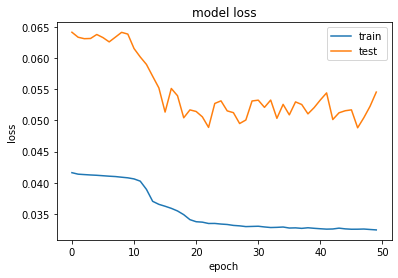

In [33]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [35]:
size = df.shape[1]

In [36]:
yhat = model.predict(X_test)

In [37]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

In [38]:
inv_yhat = np.concatenate((yhat, X_test[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat.shape

(5205,)

In [39]:
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y.shape

(5205,)

In [40]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.801


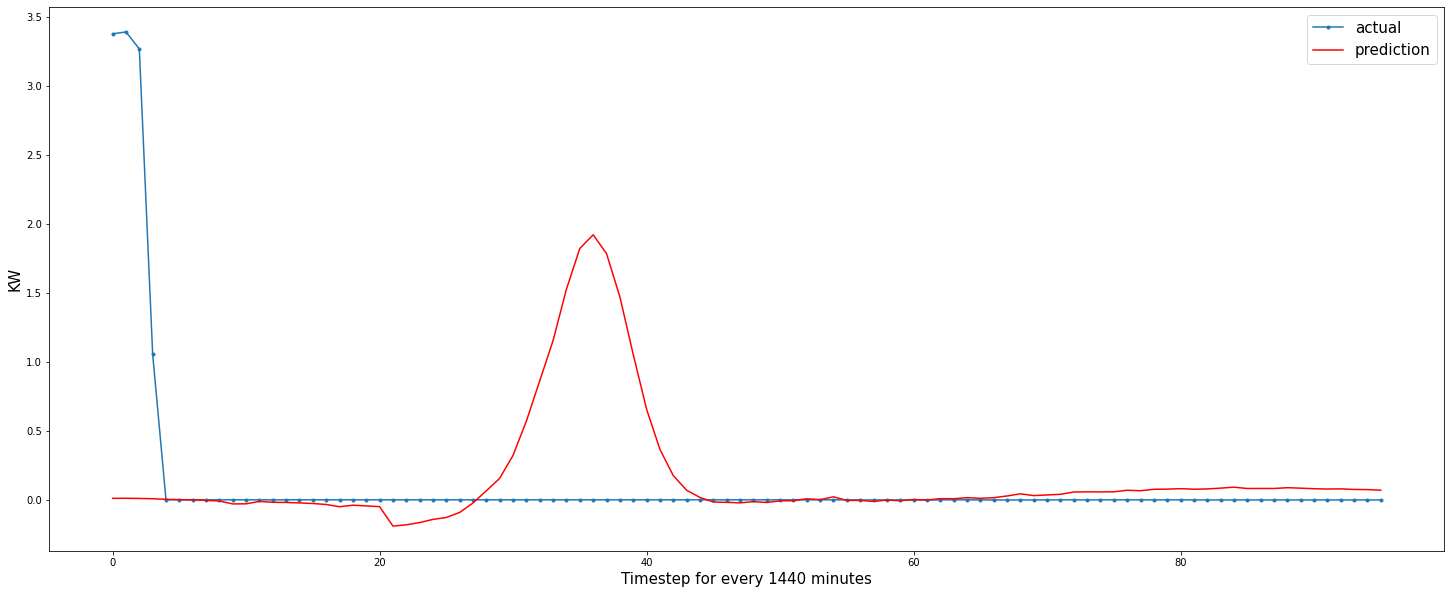

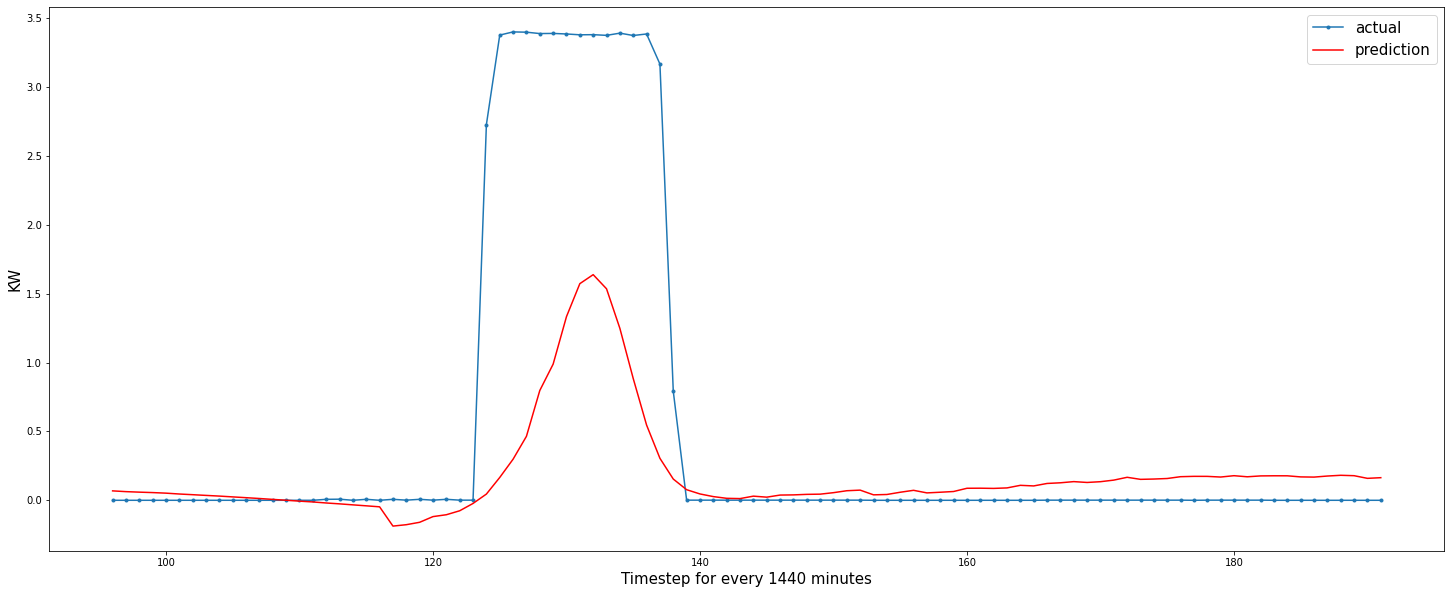

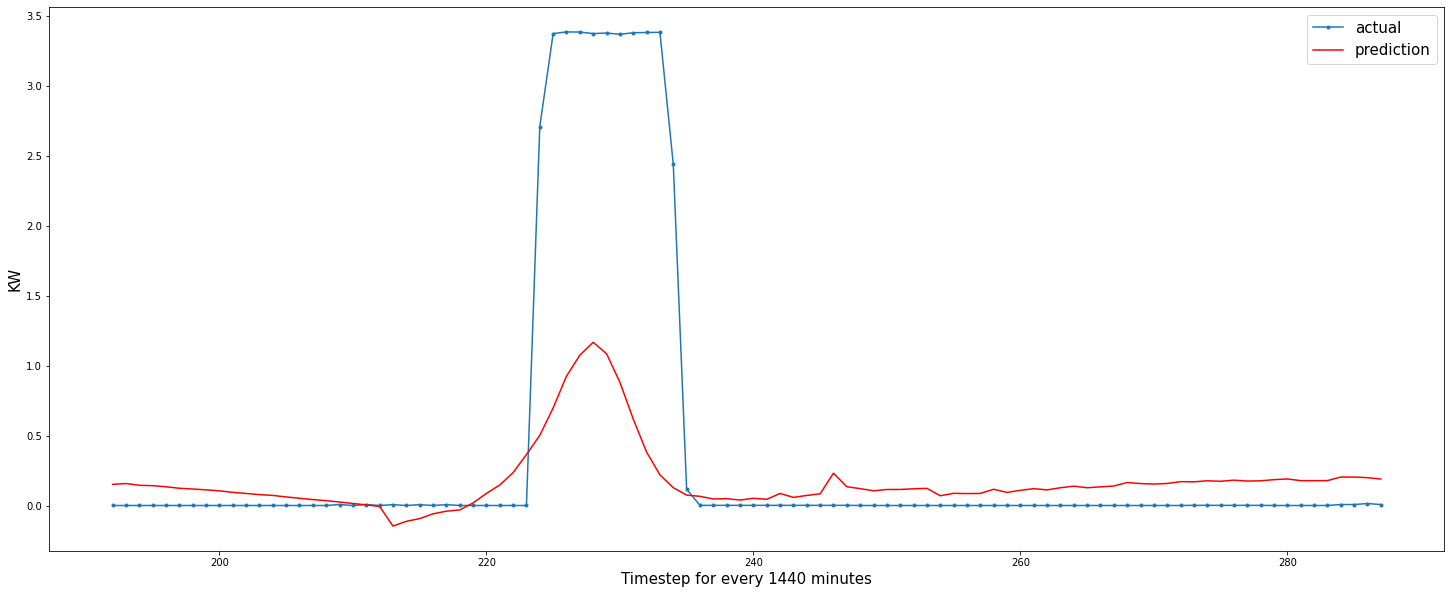

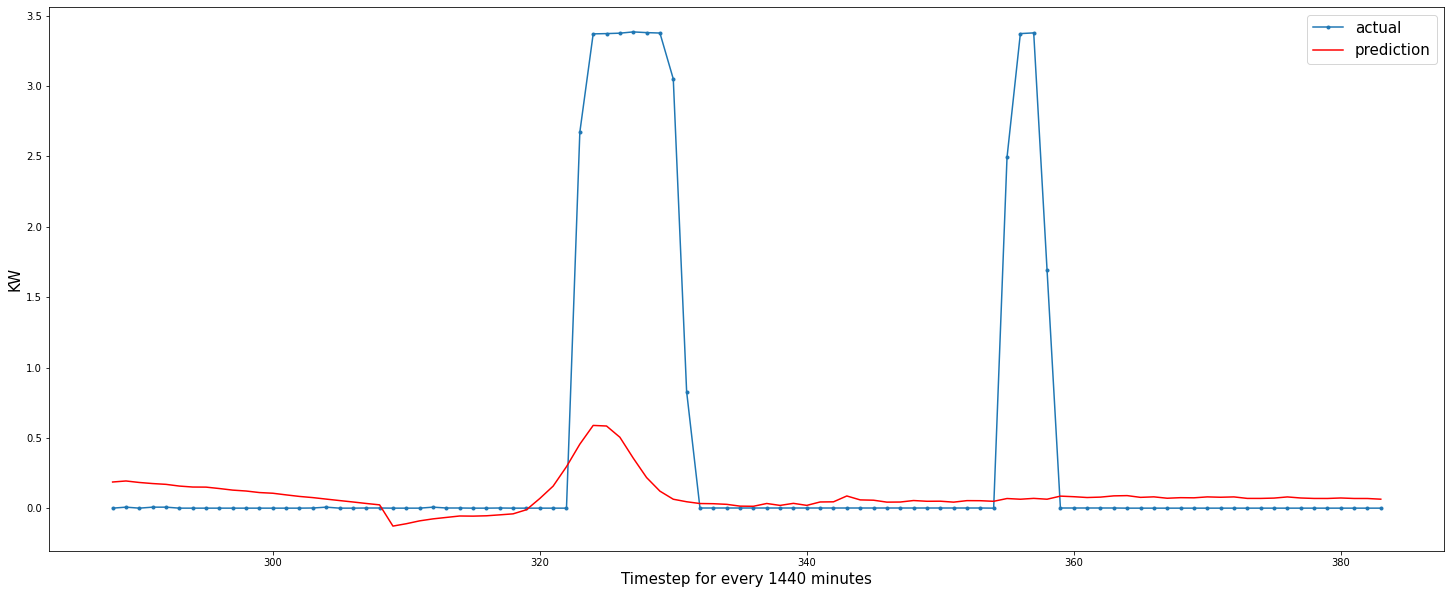

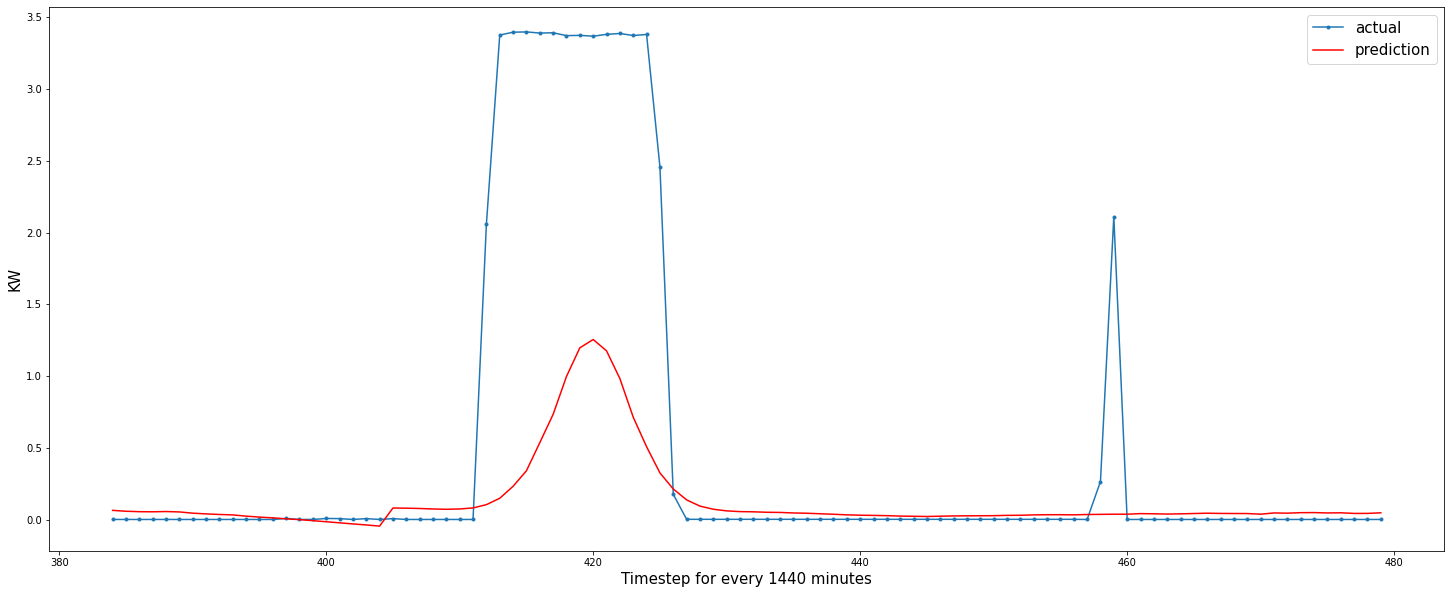

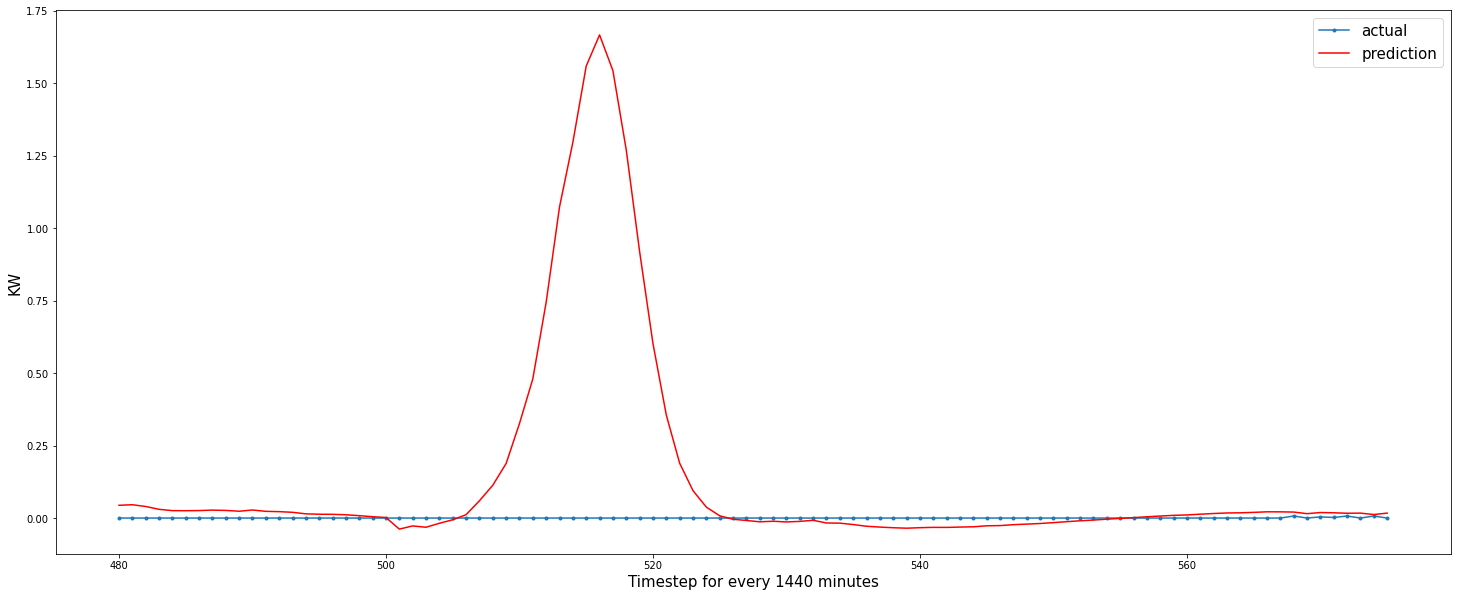

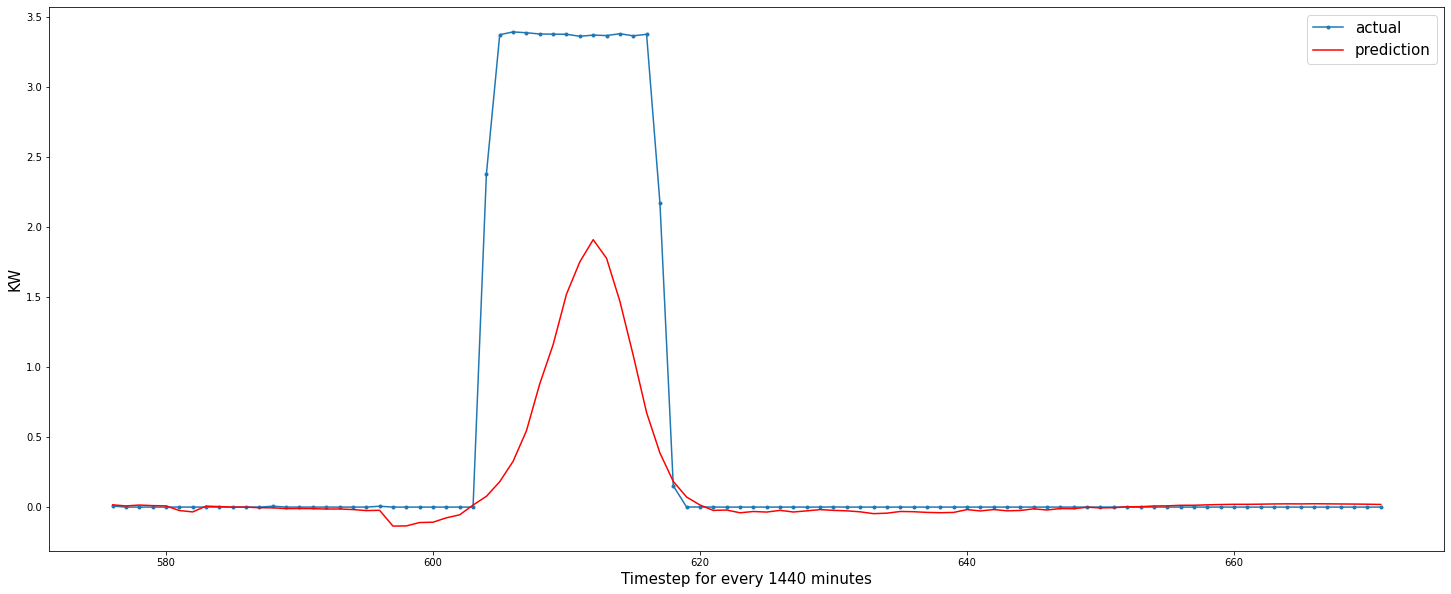

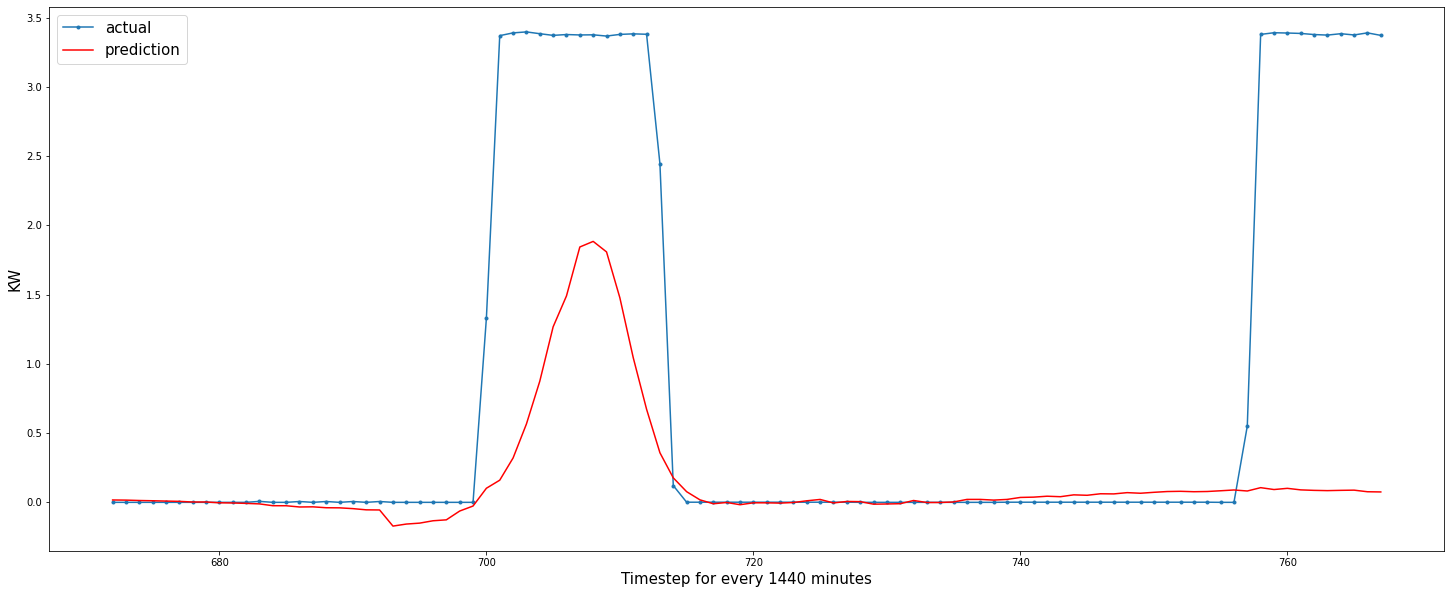

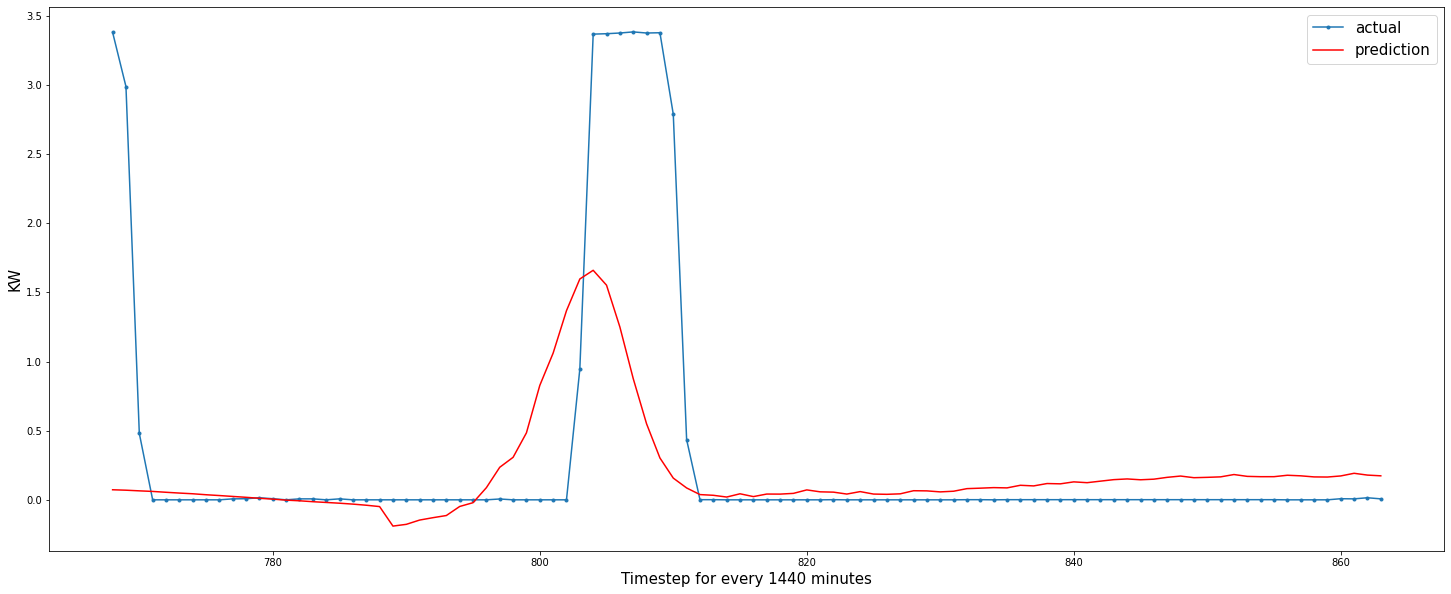

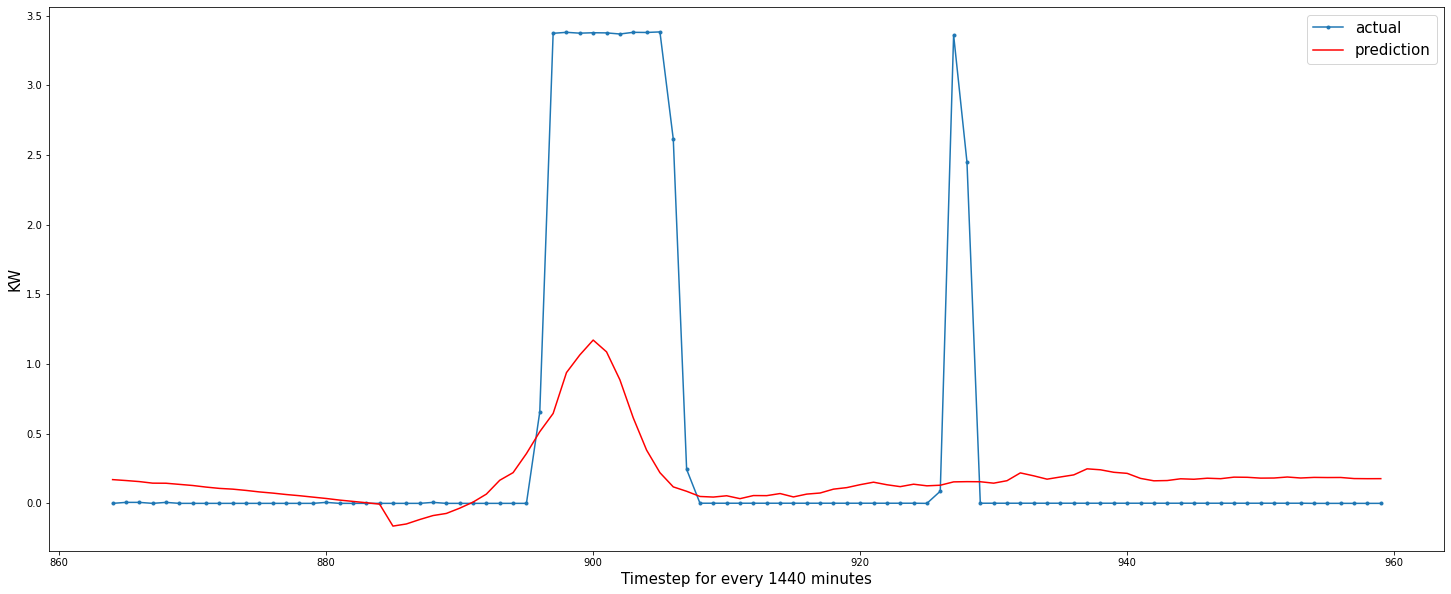

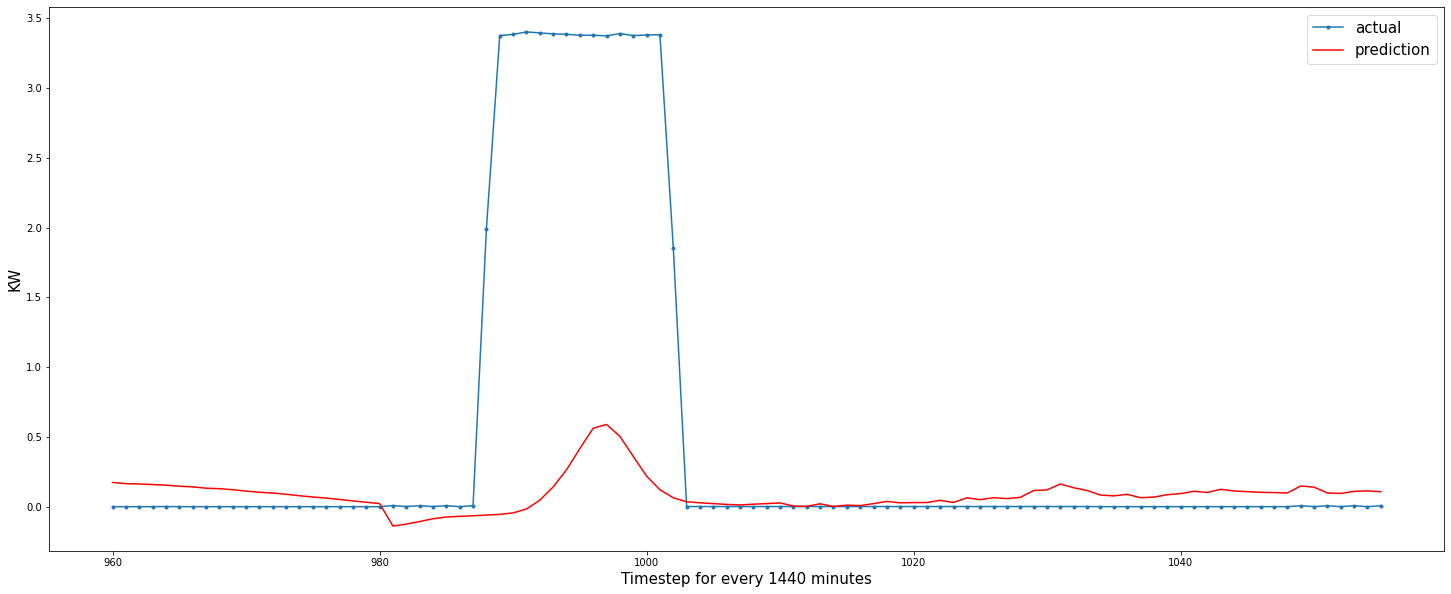

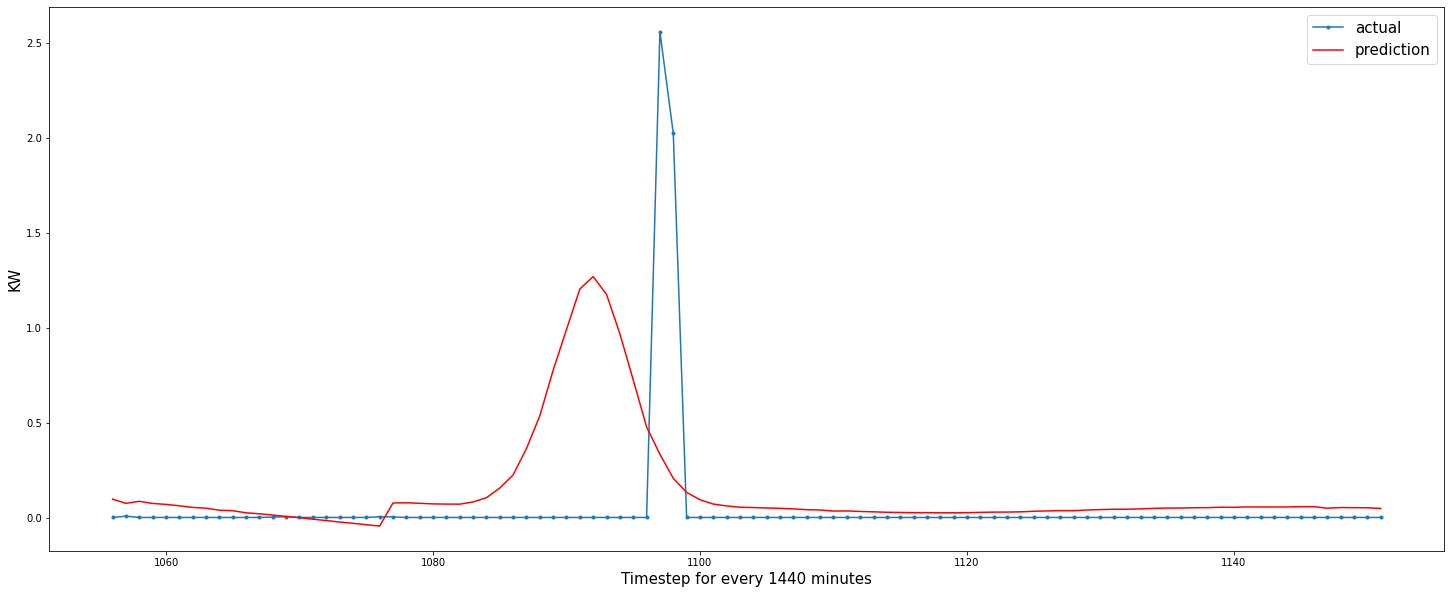

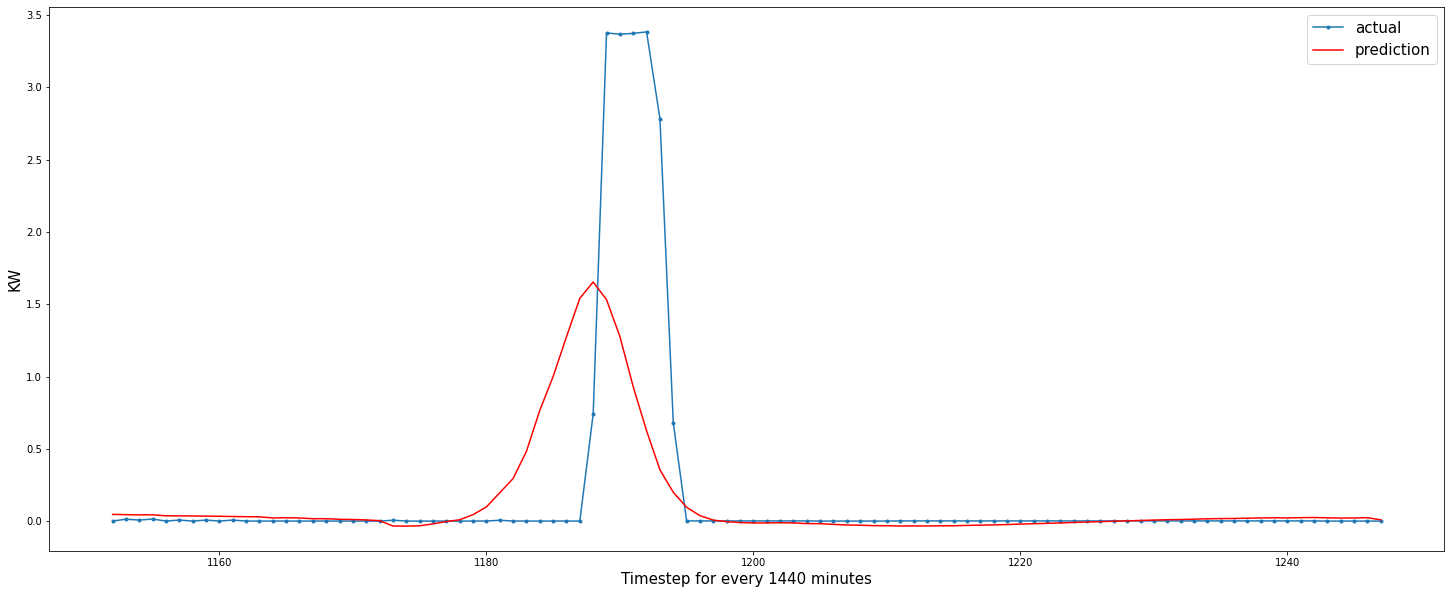

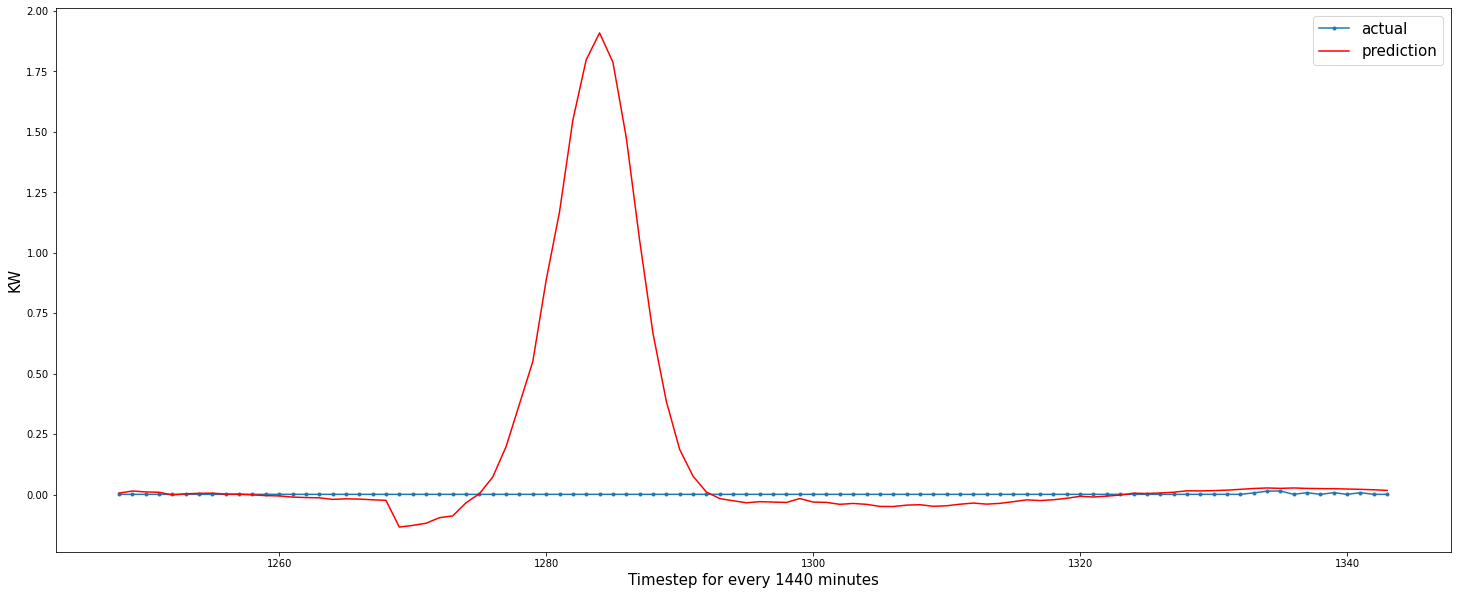

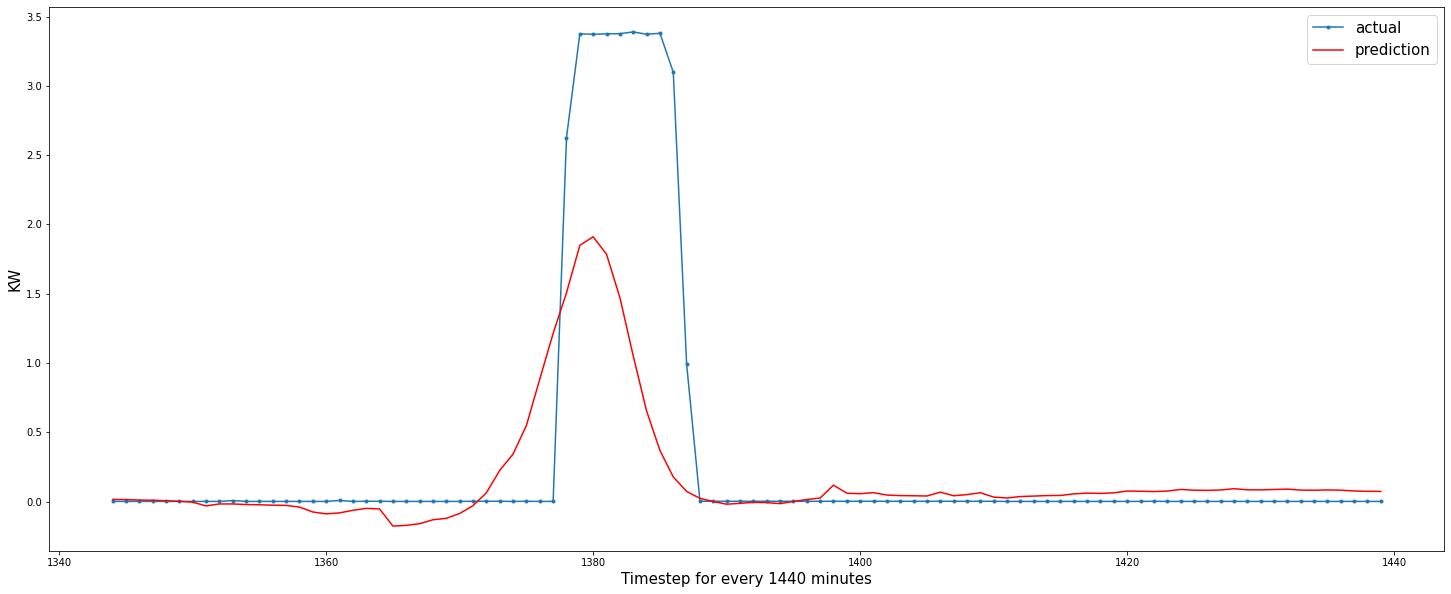

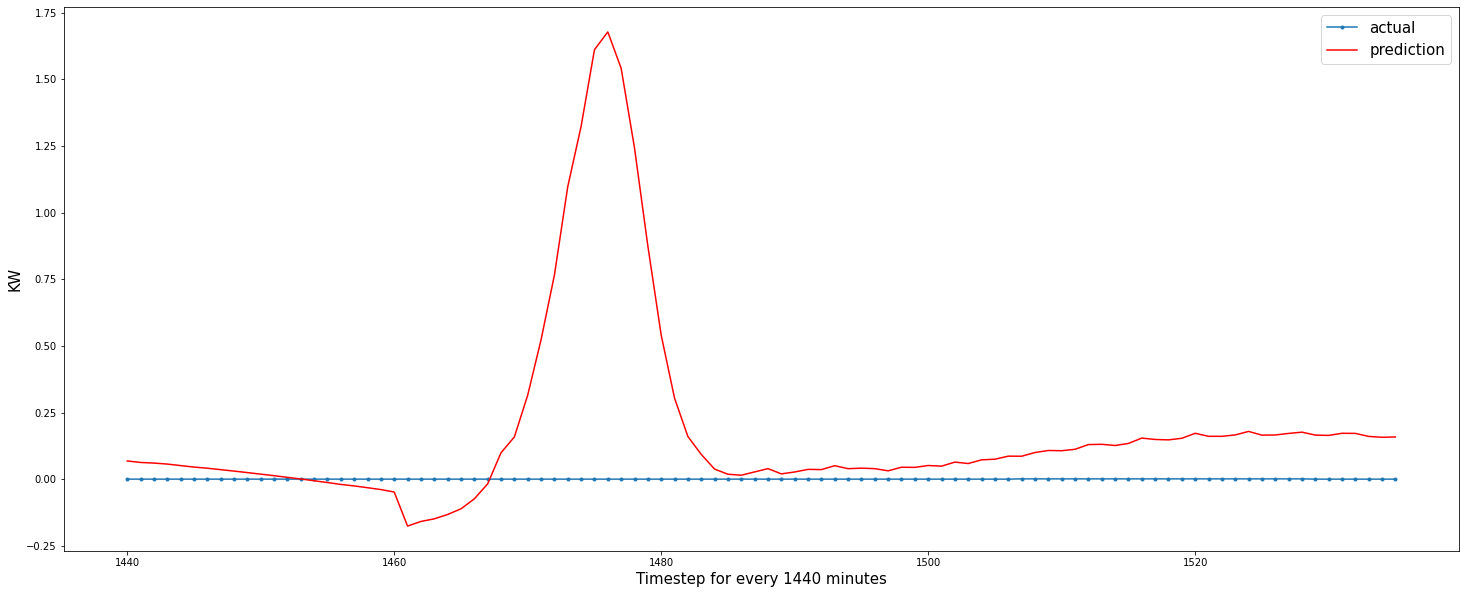

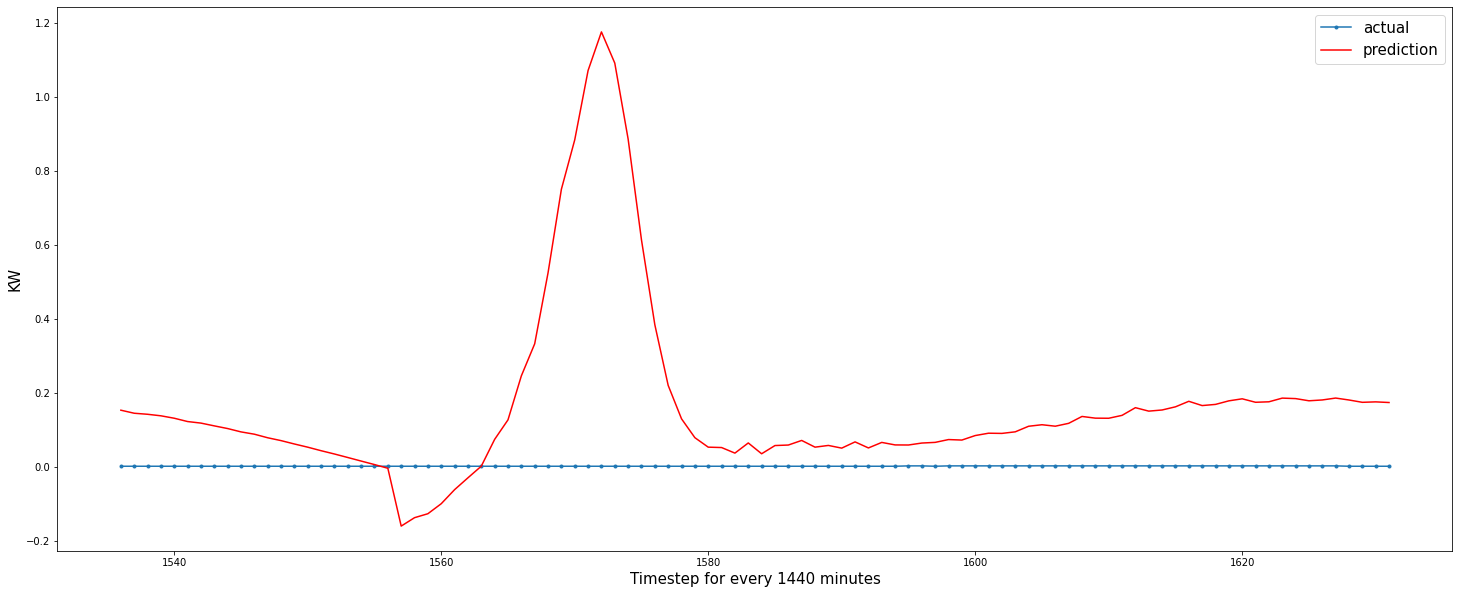

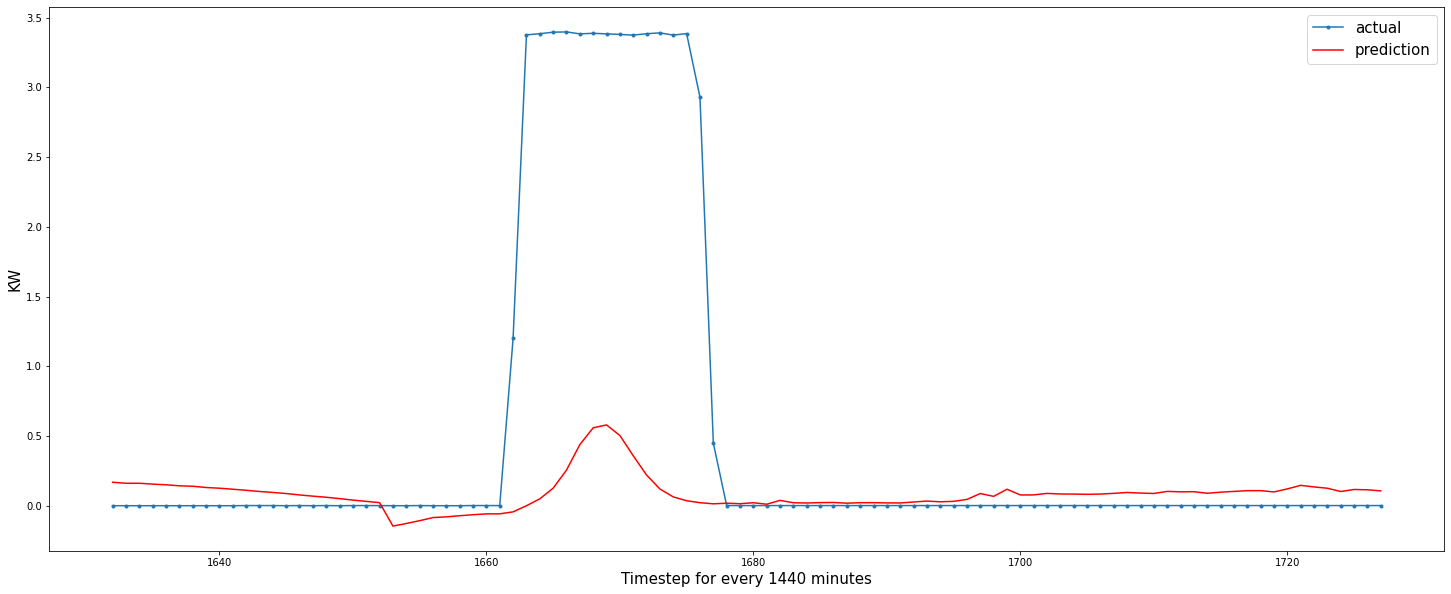

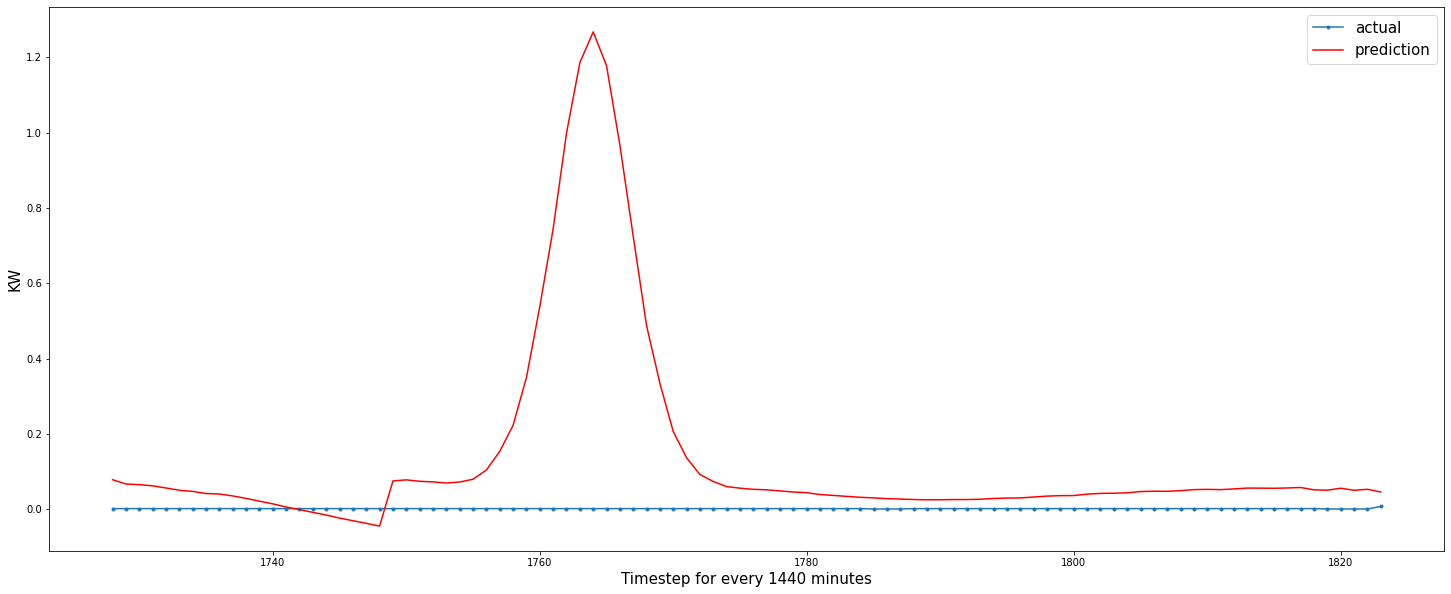

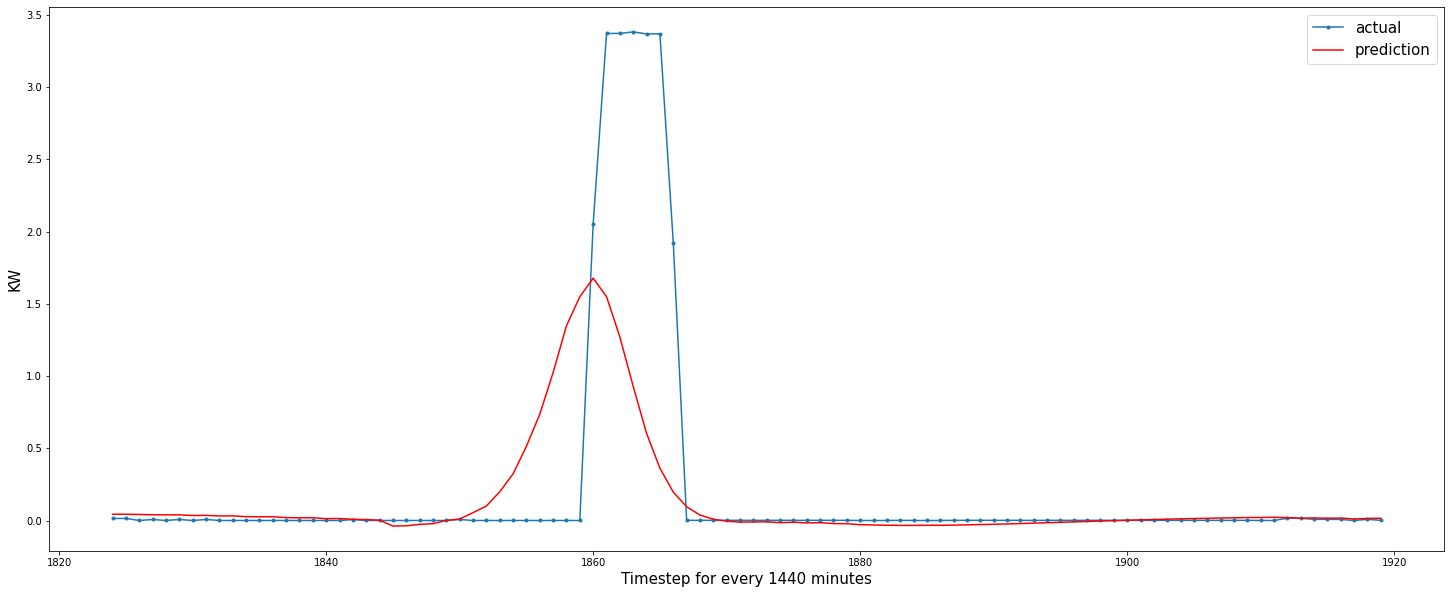

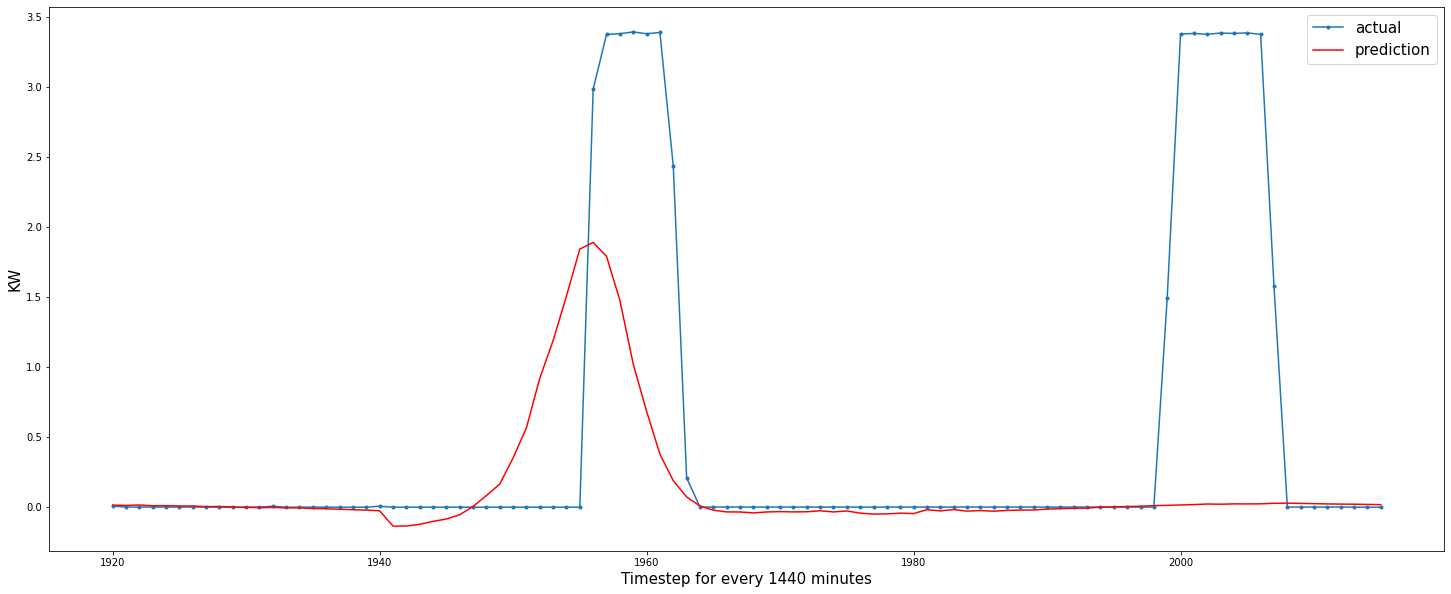

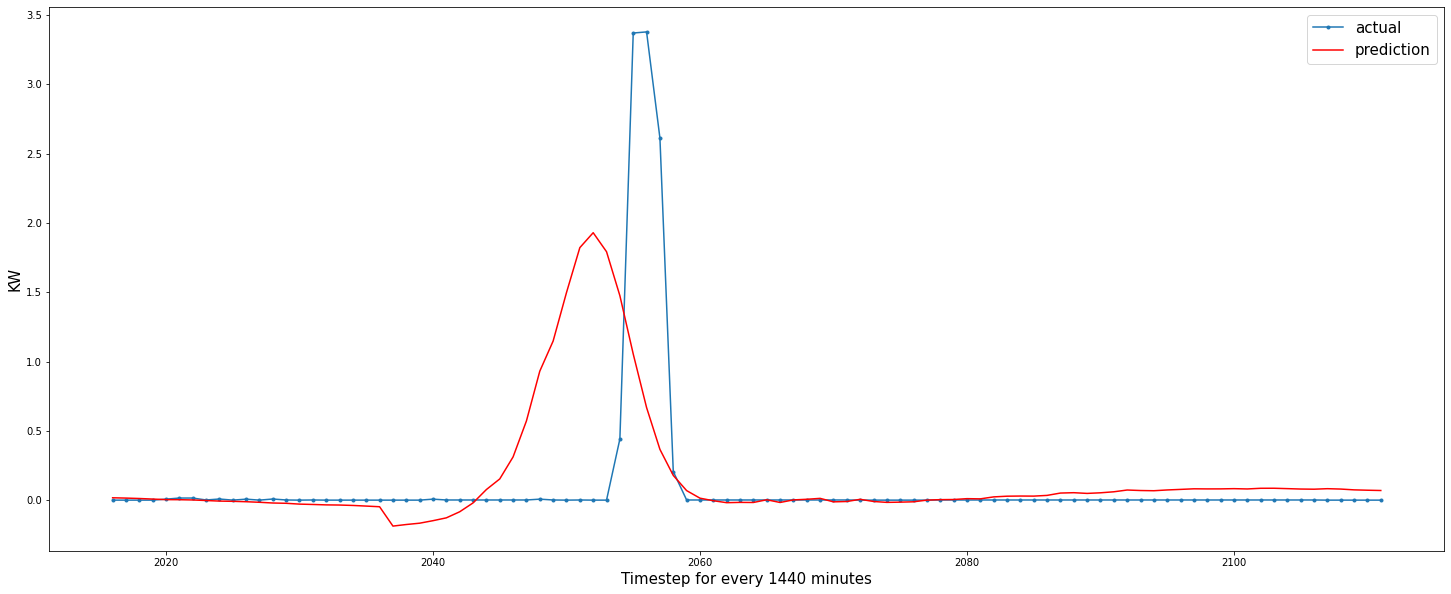

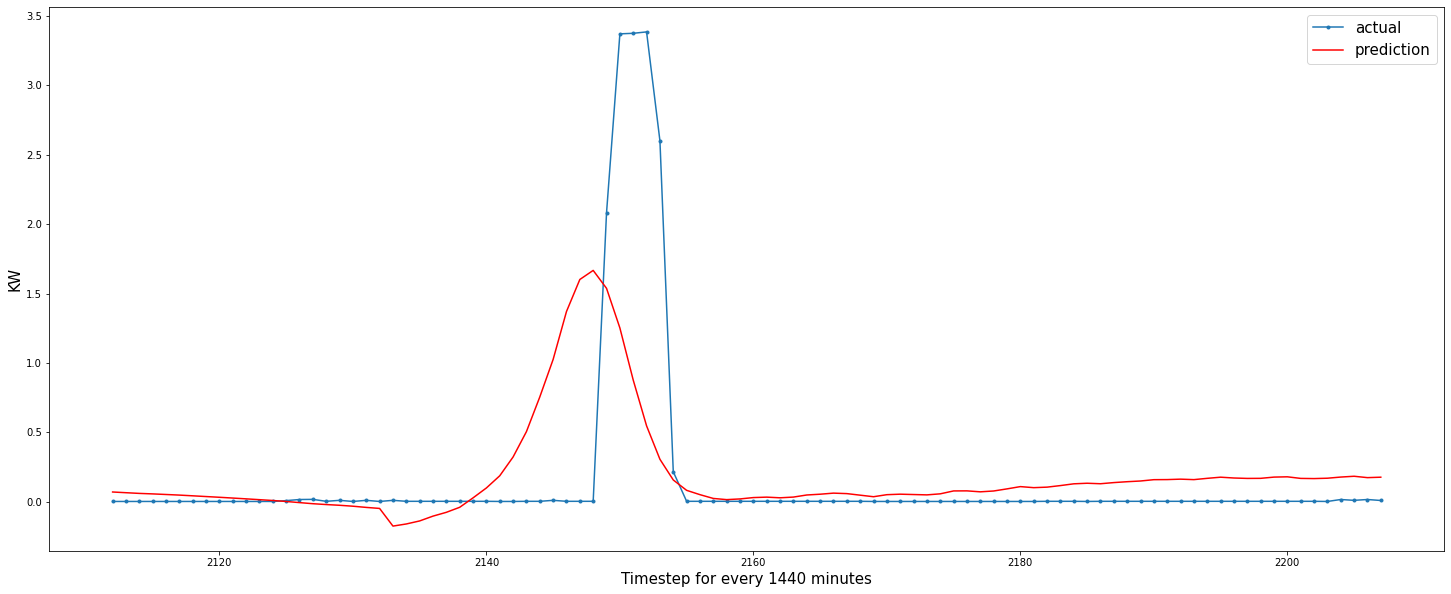

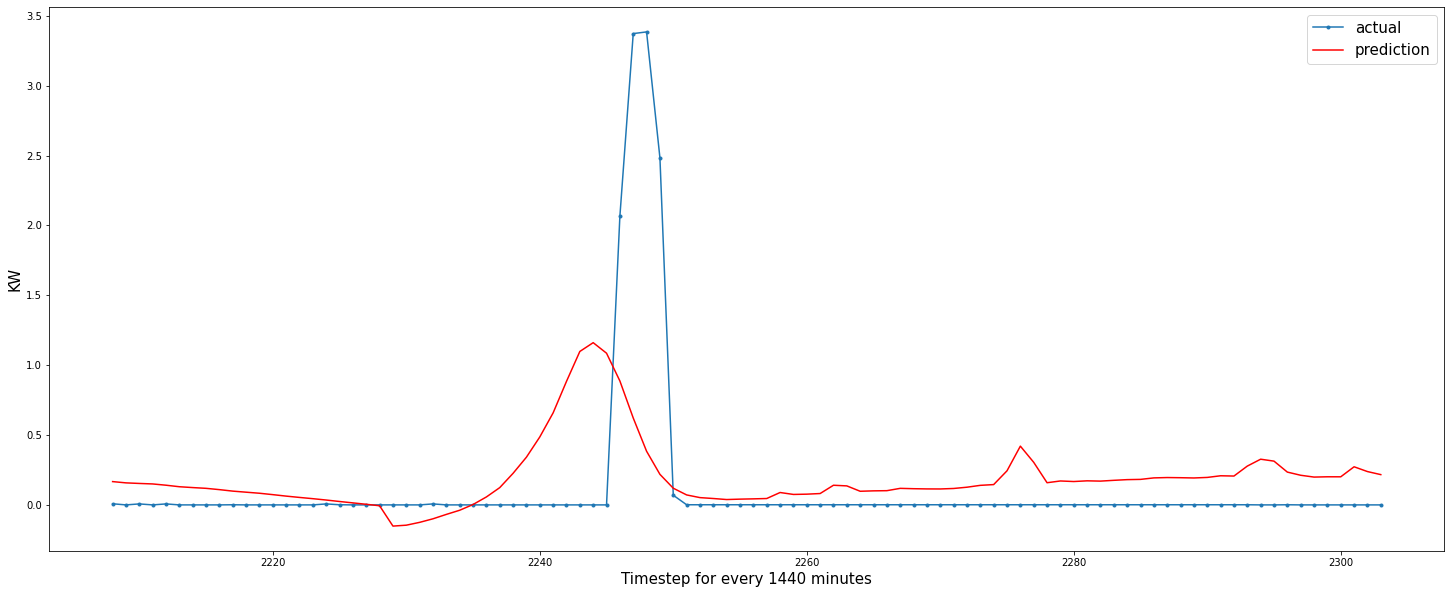

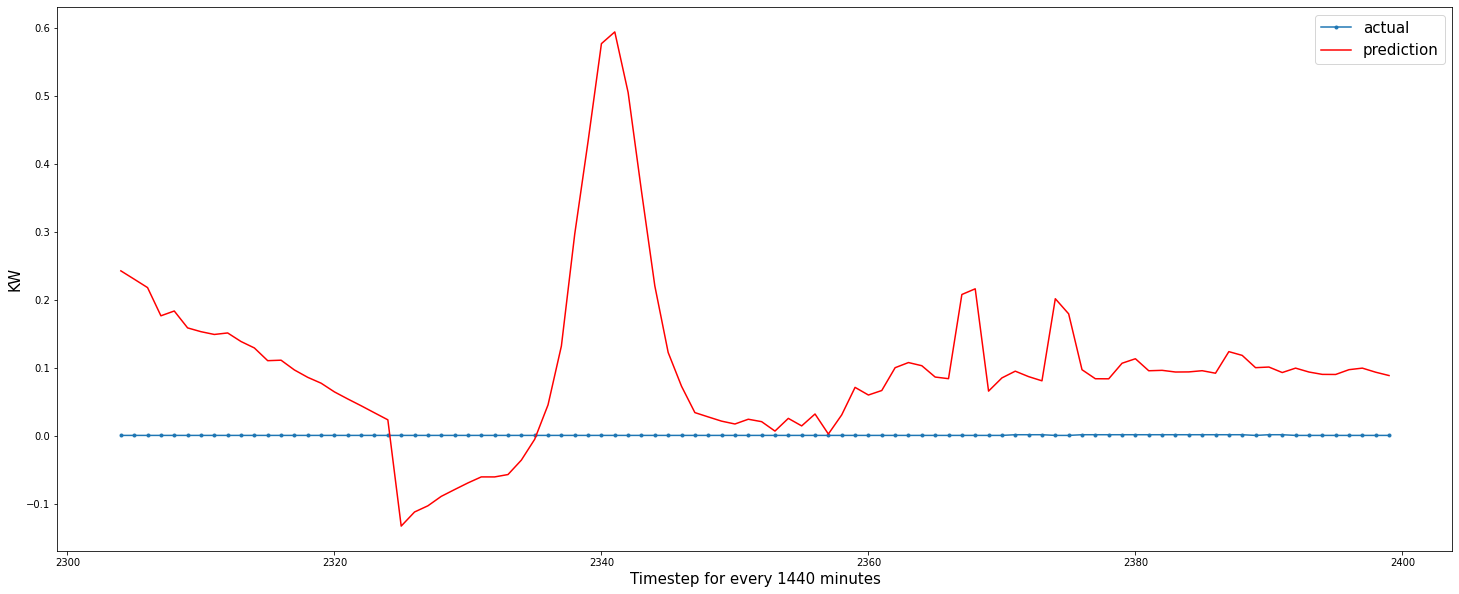

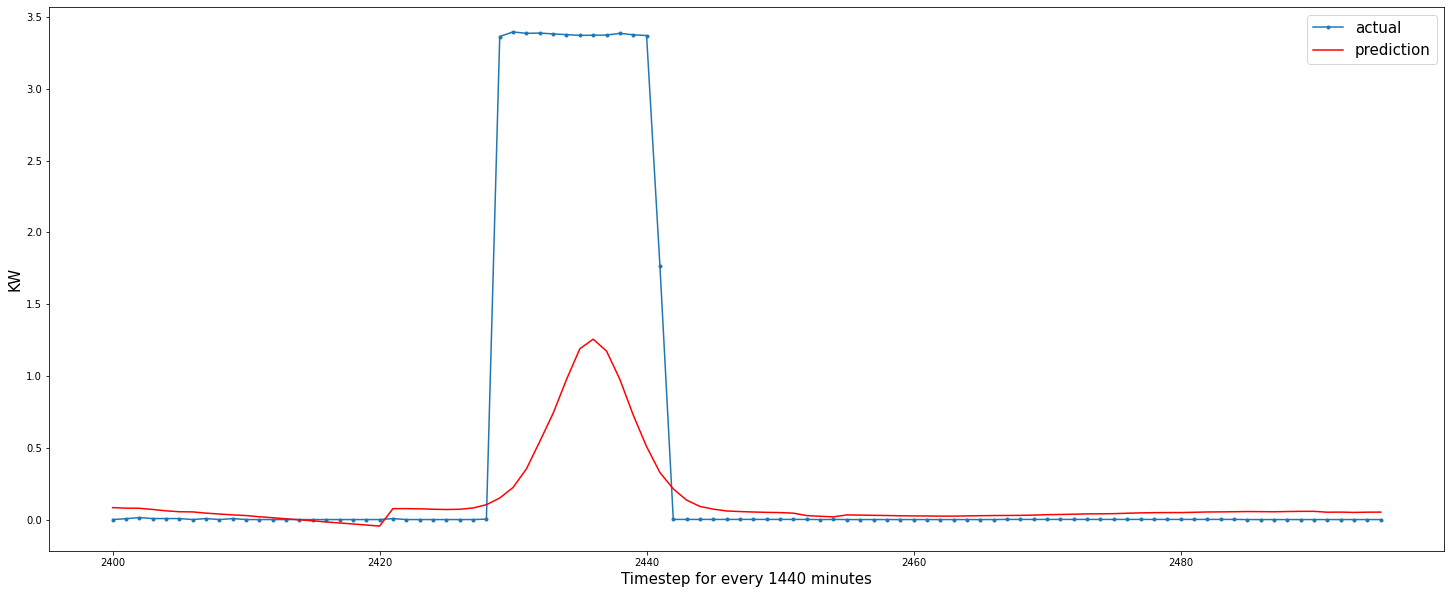

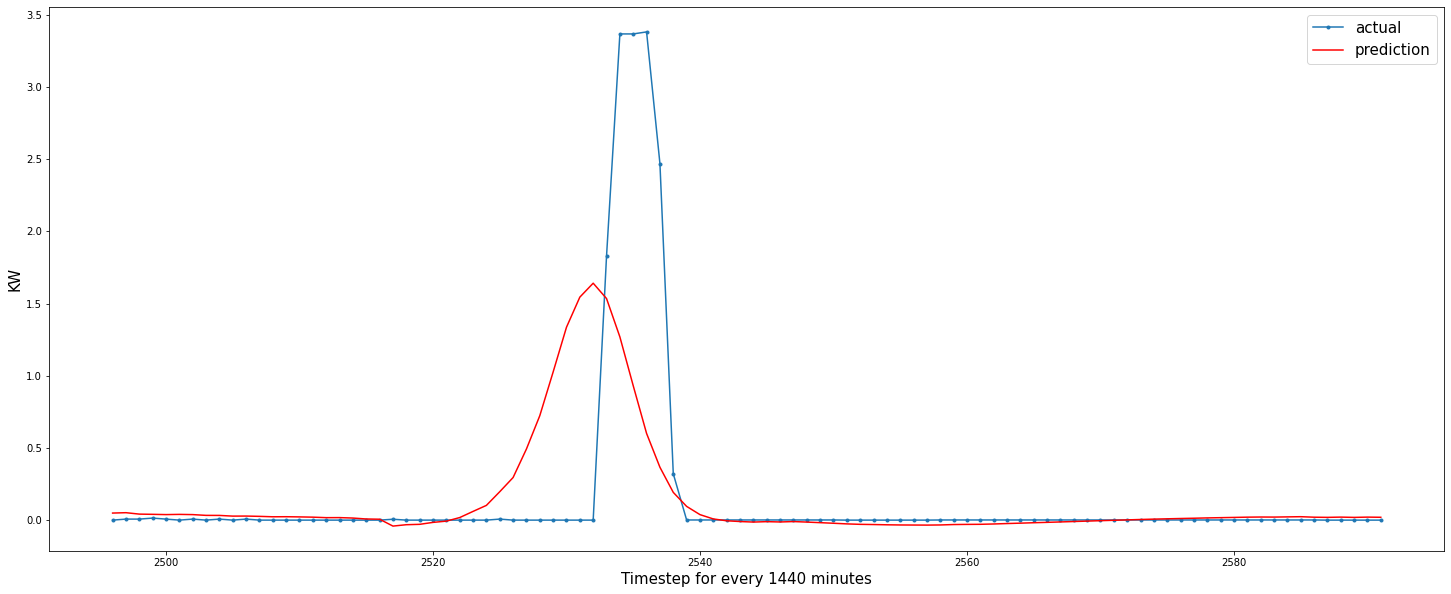

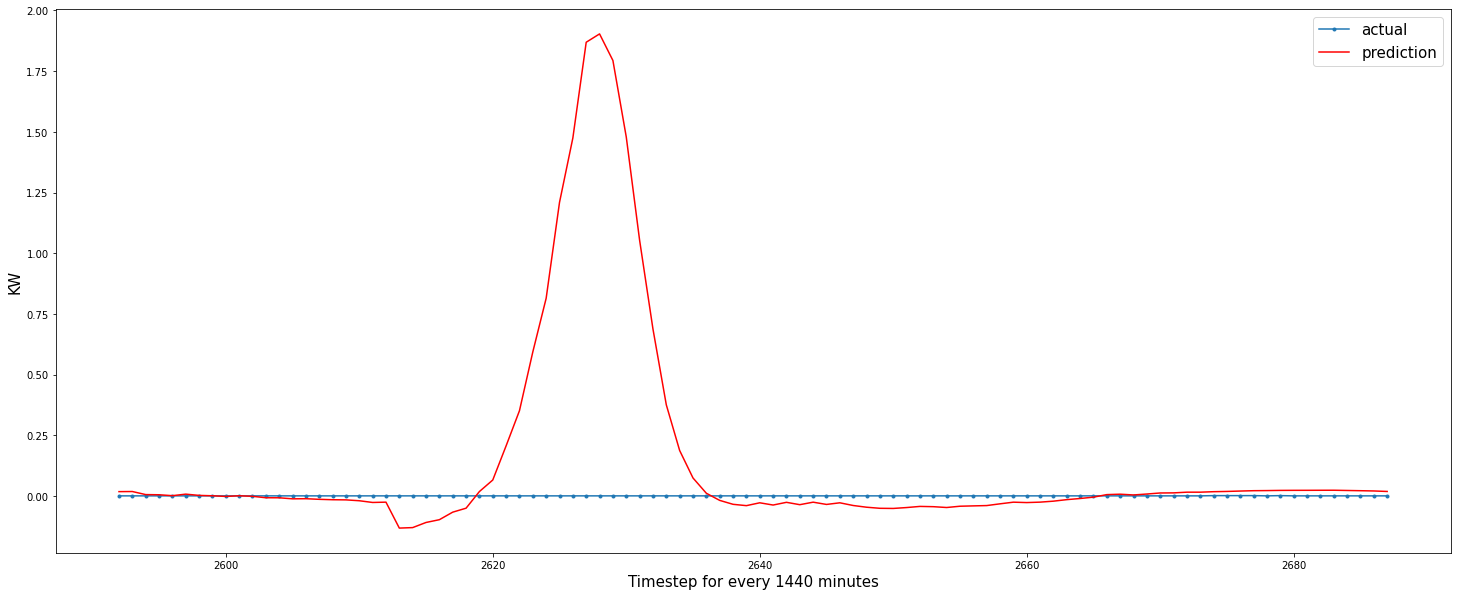

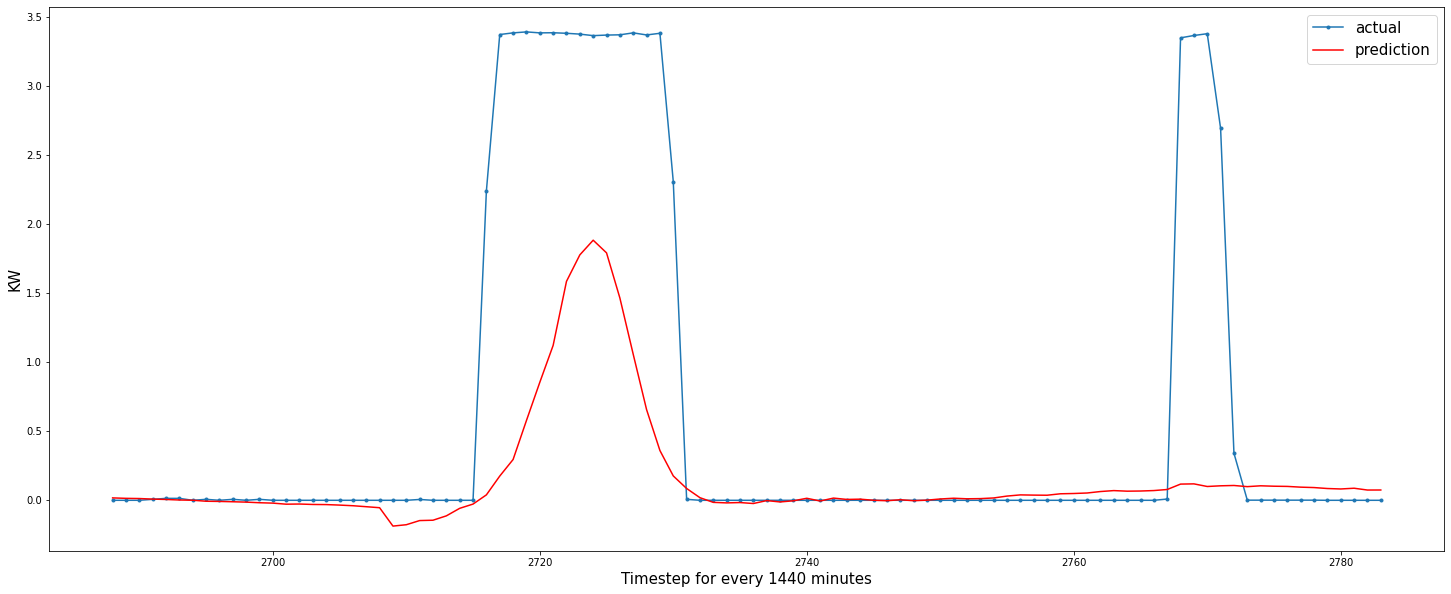

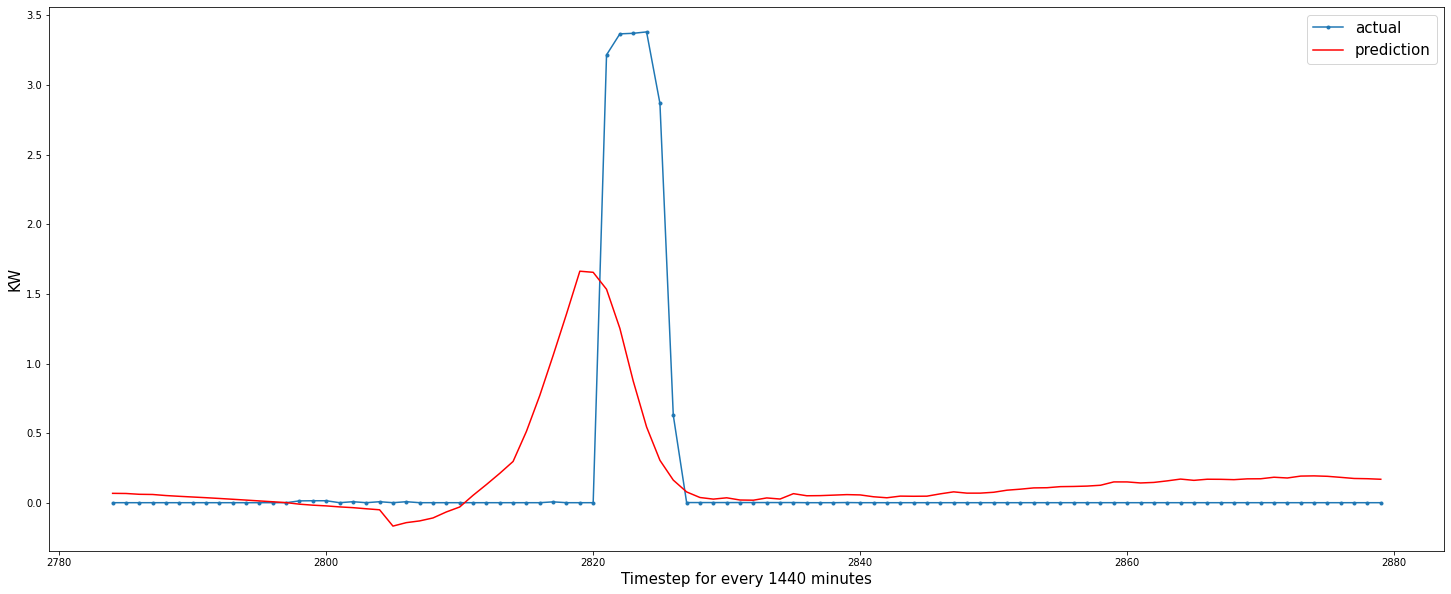

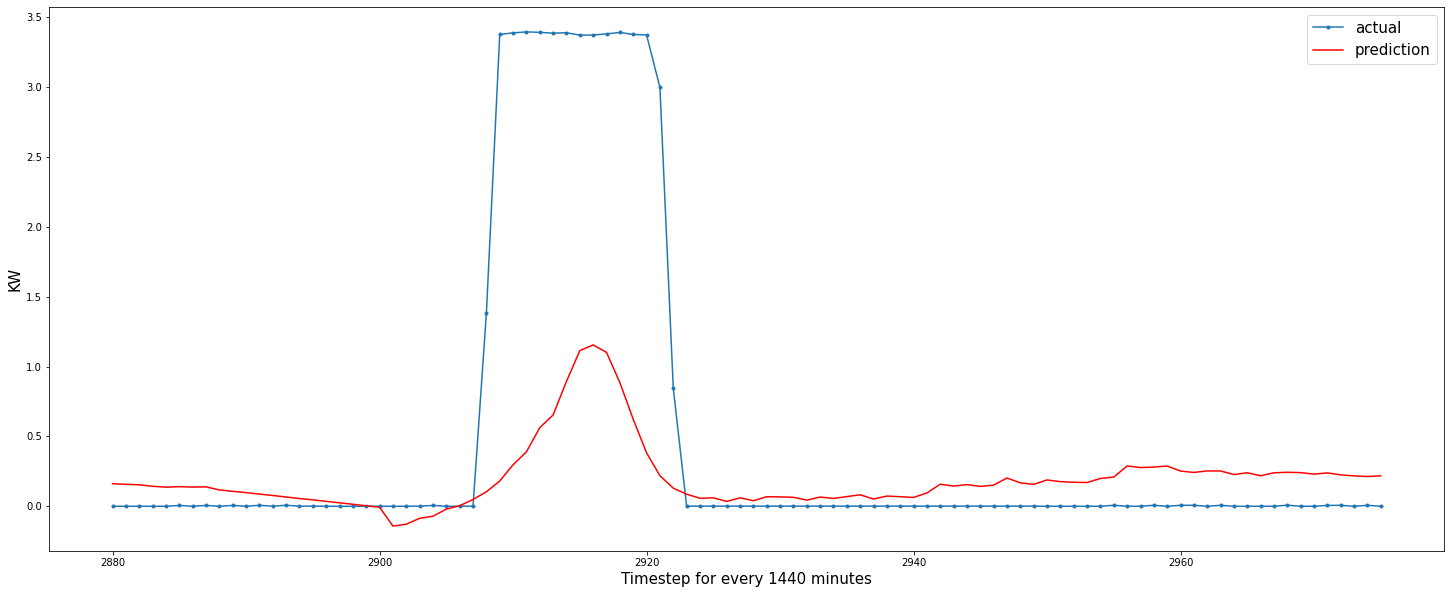

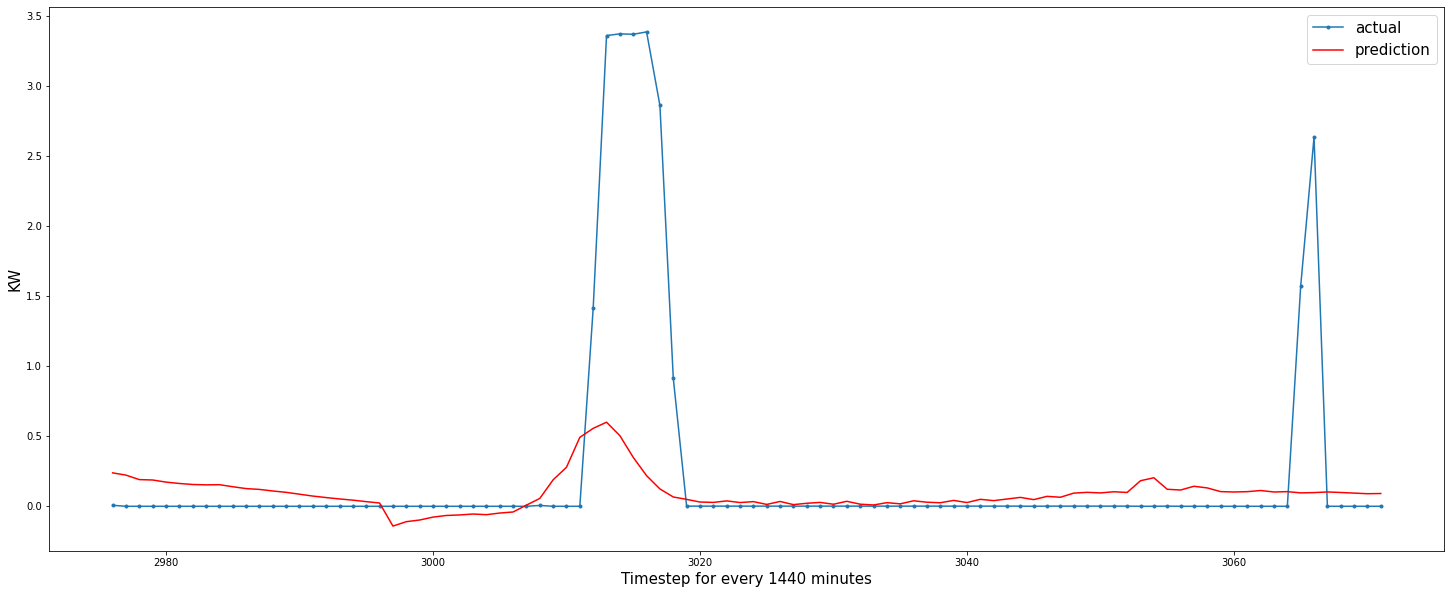

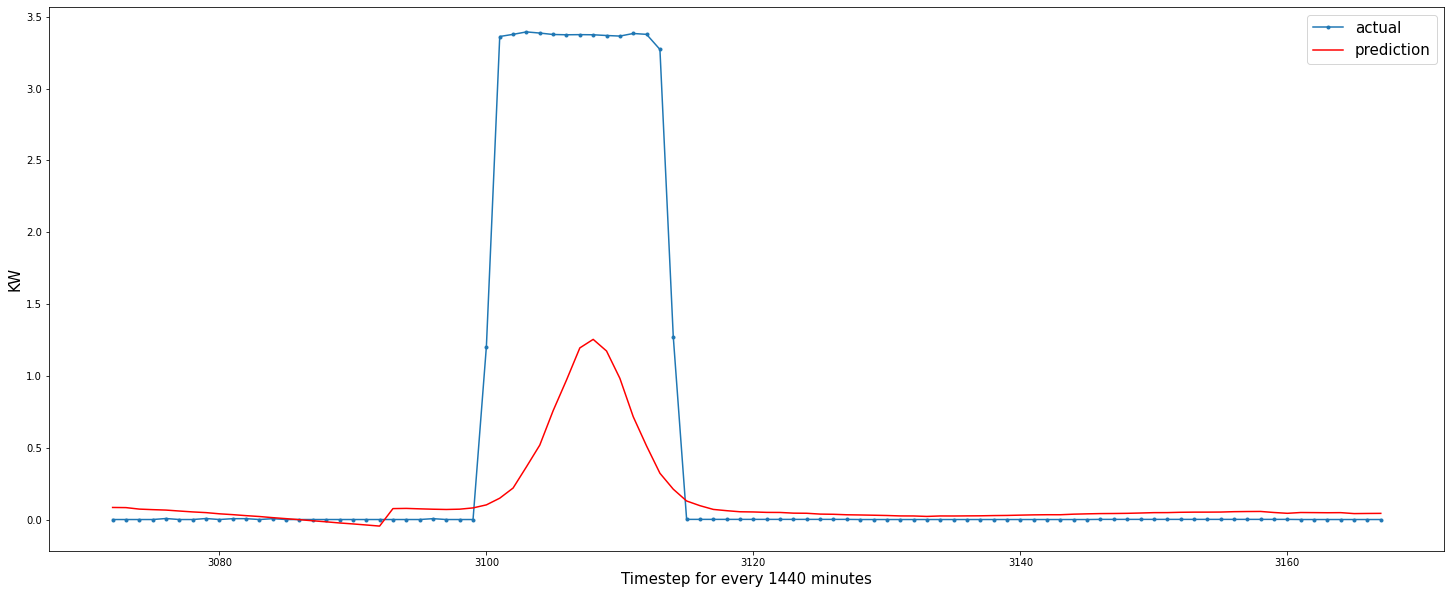

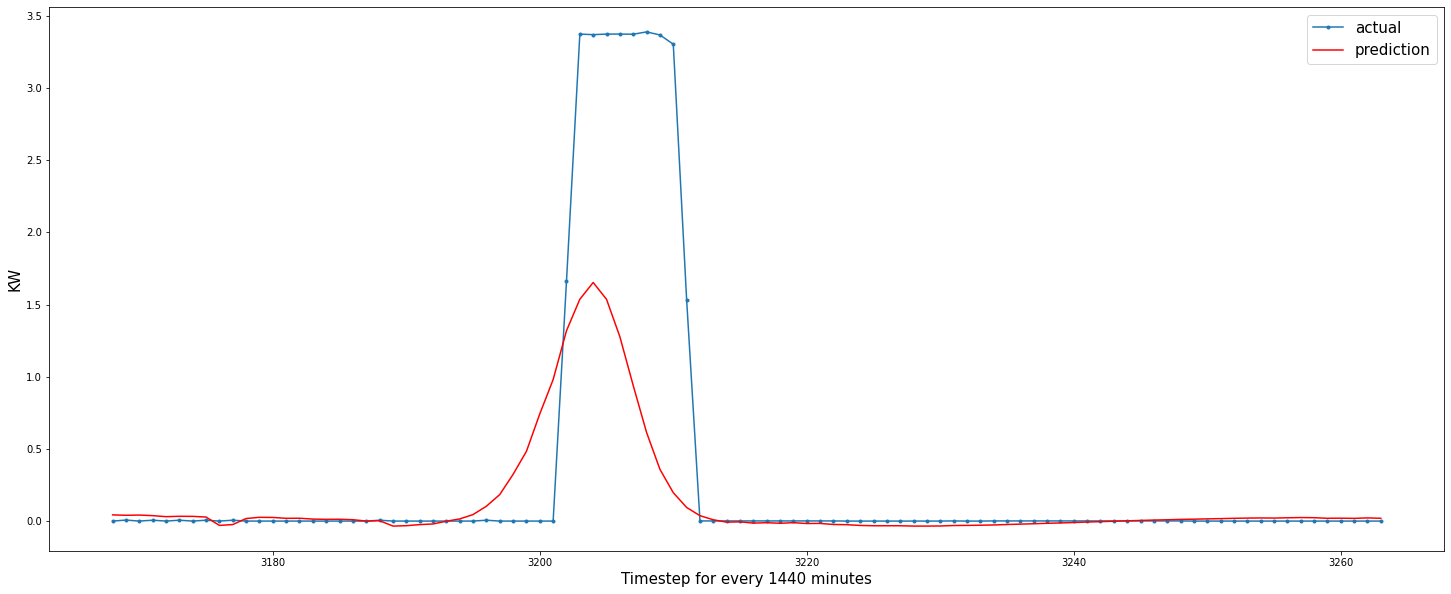

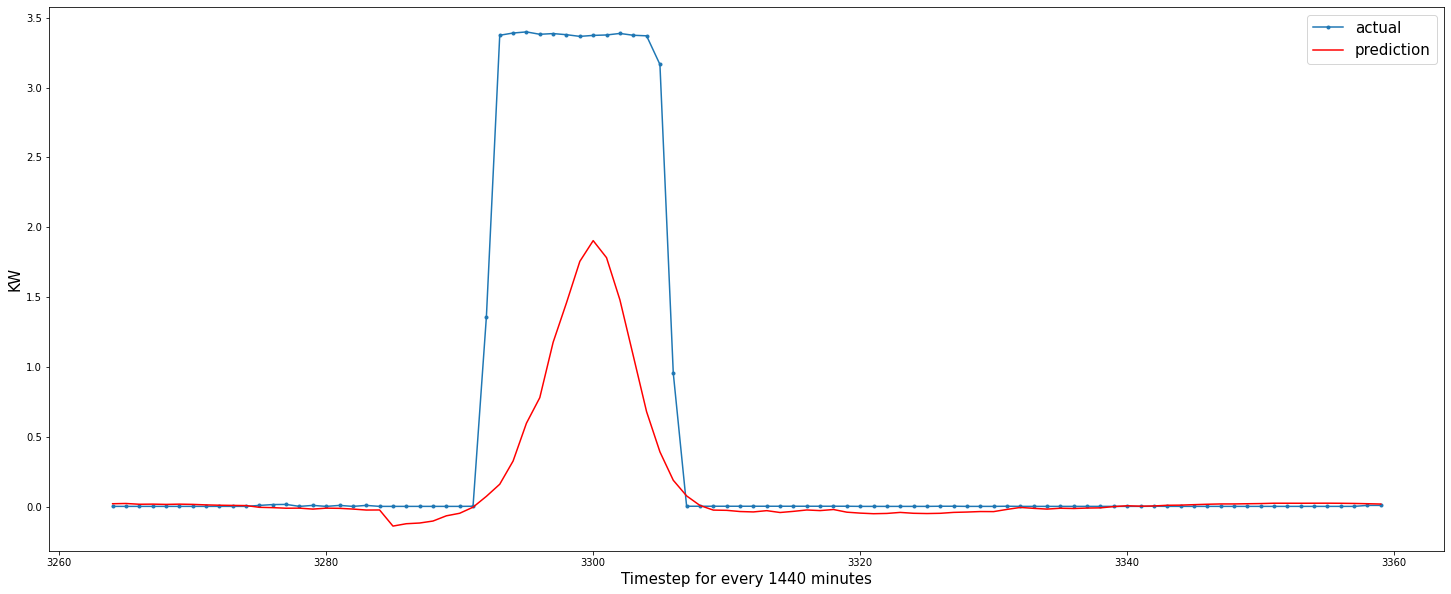

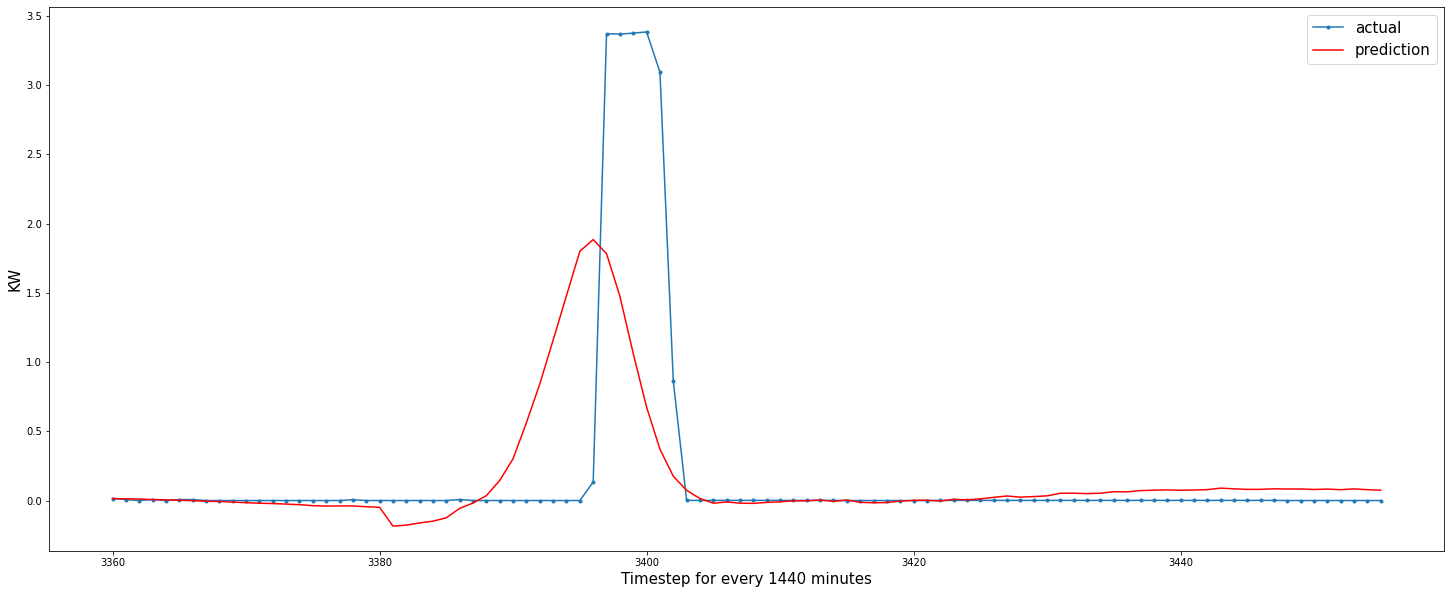

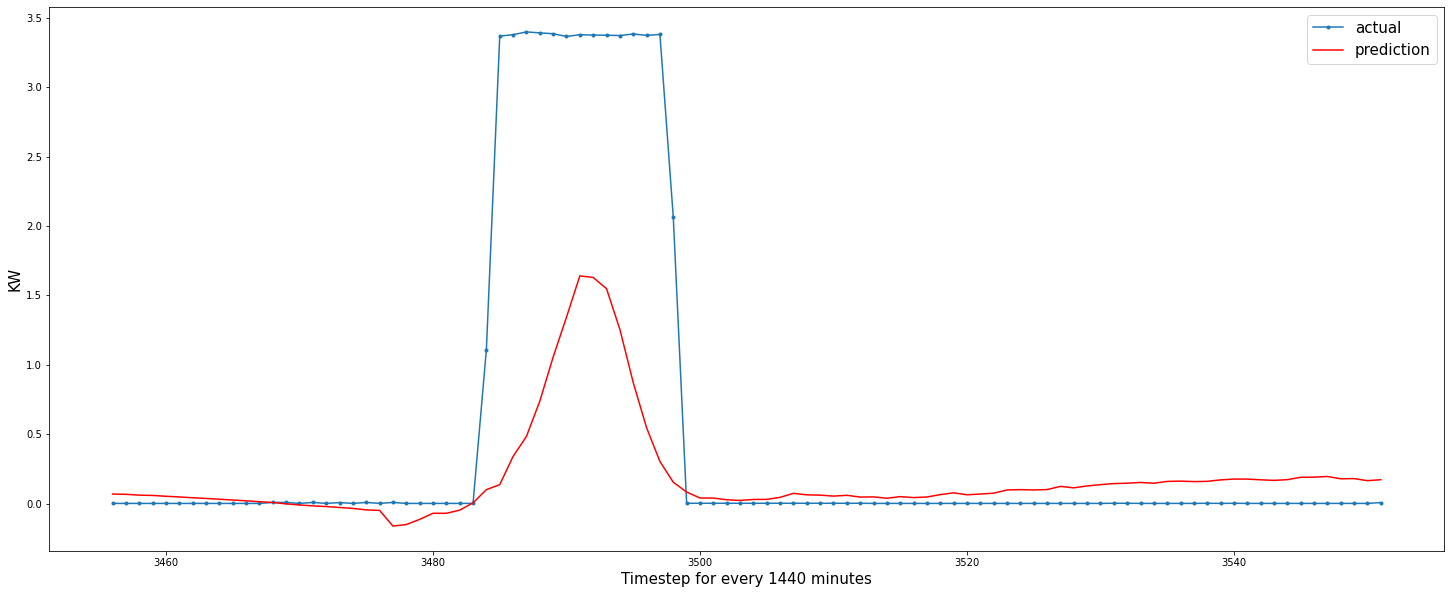

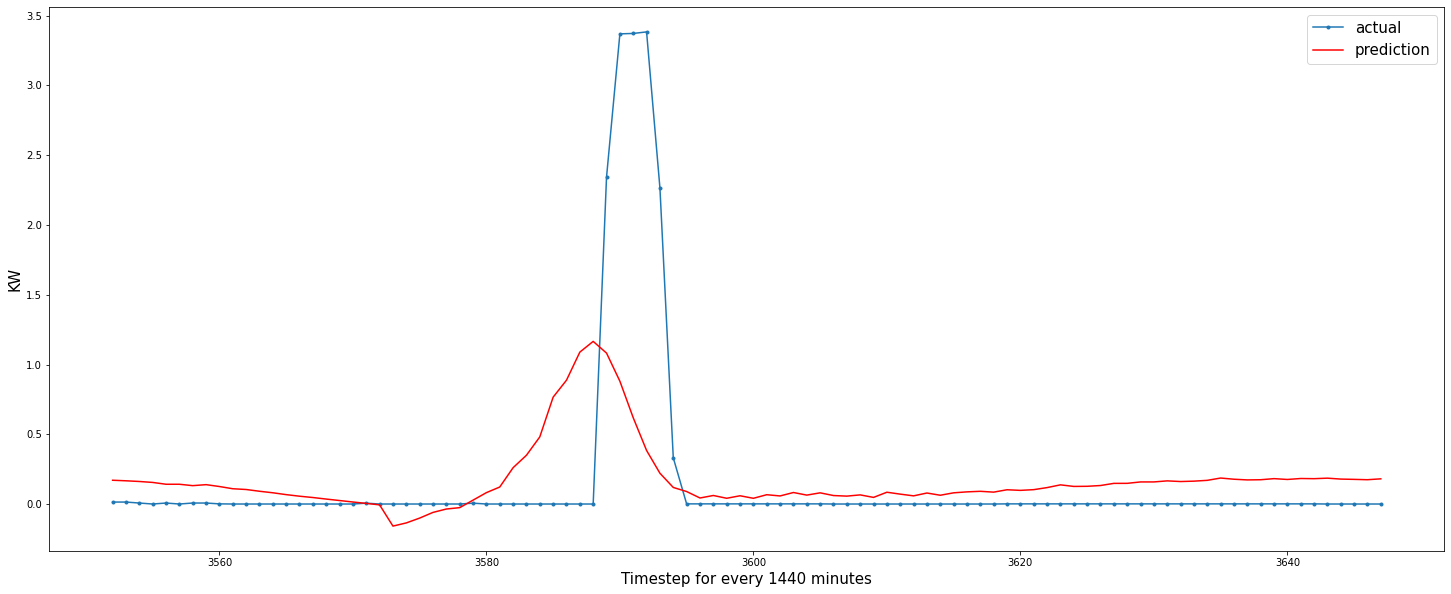

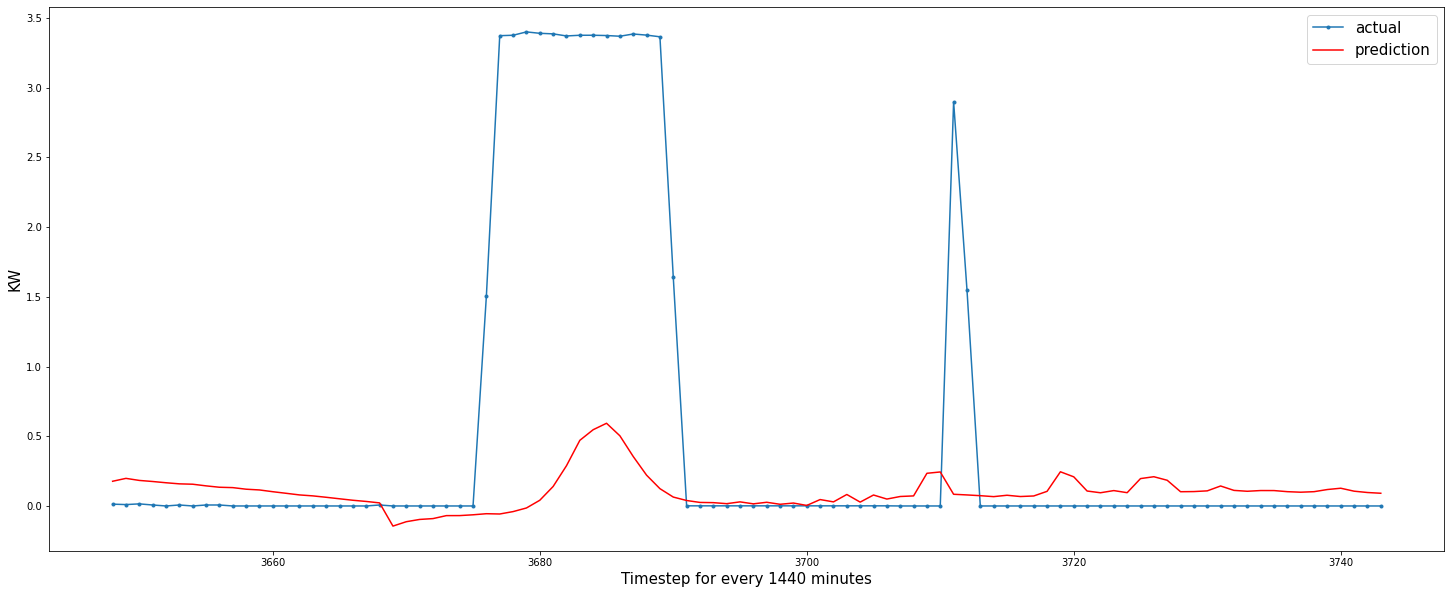

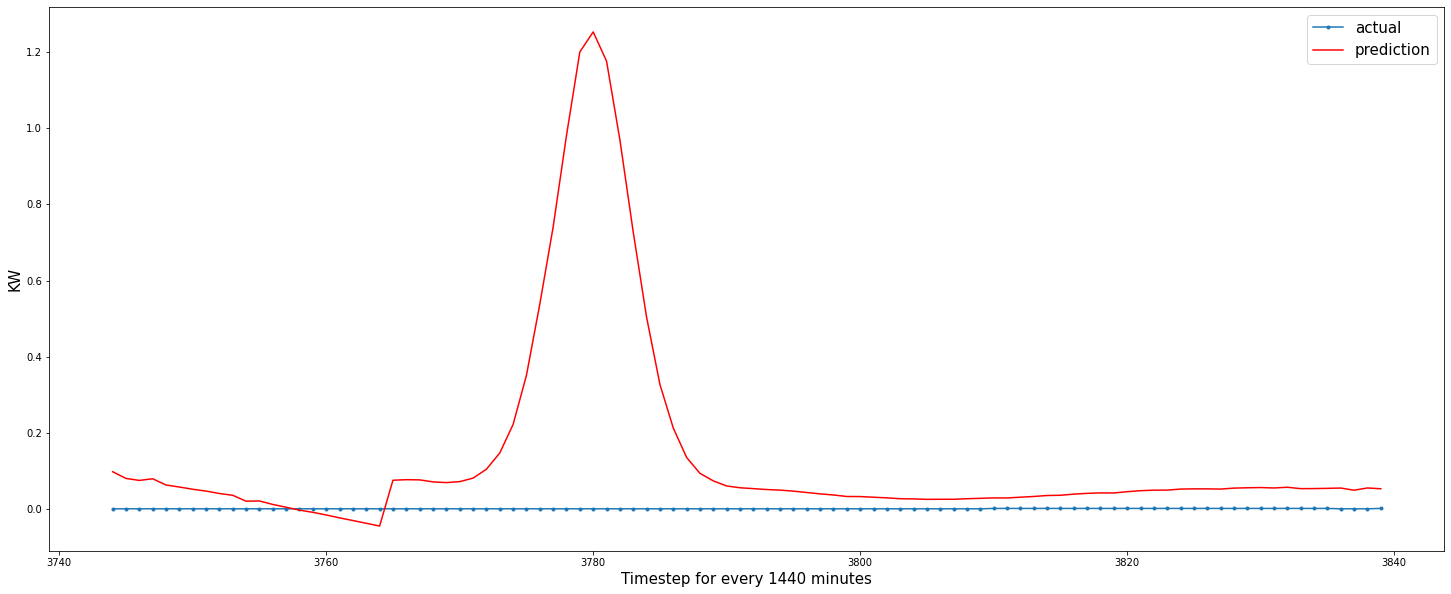

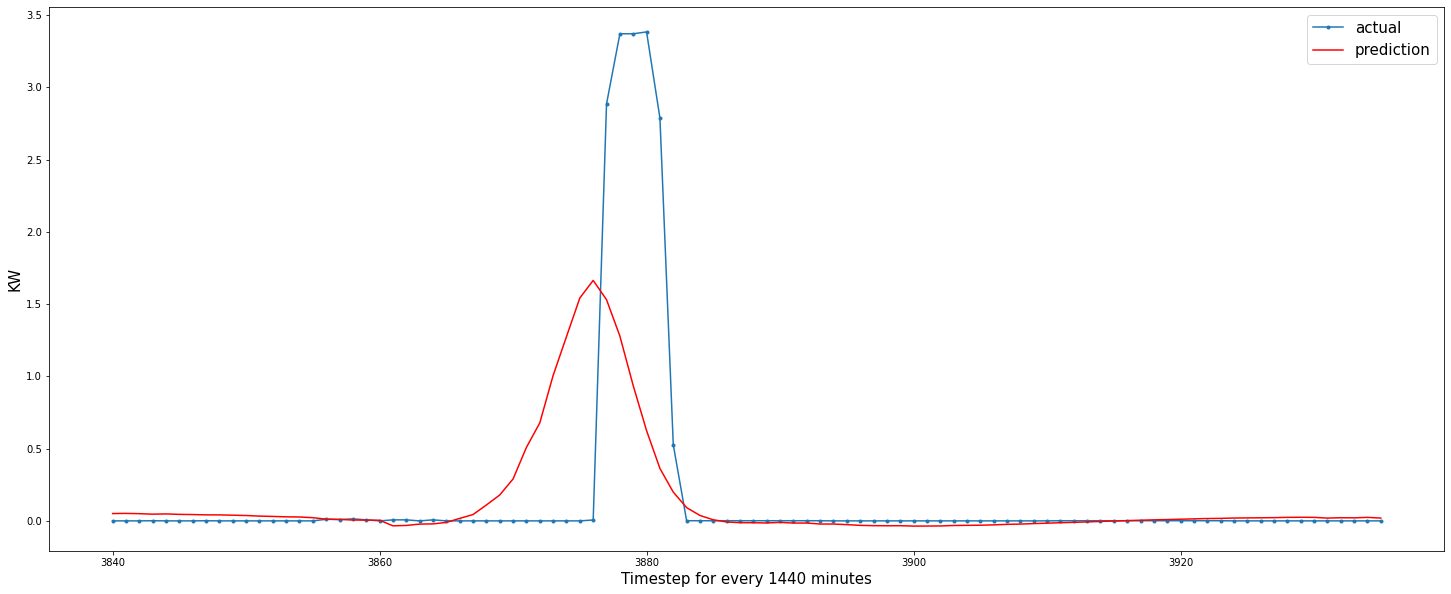

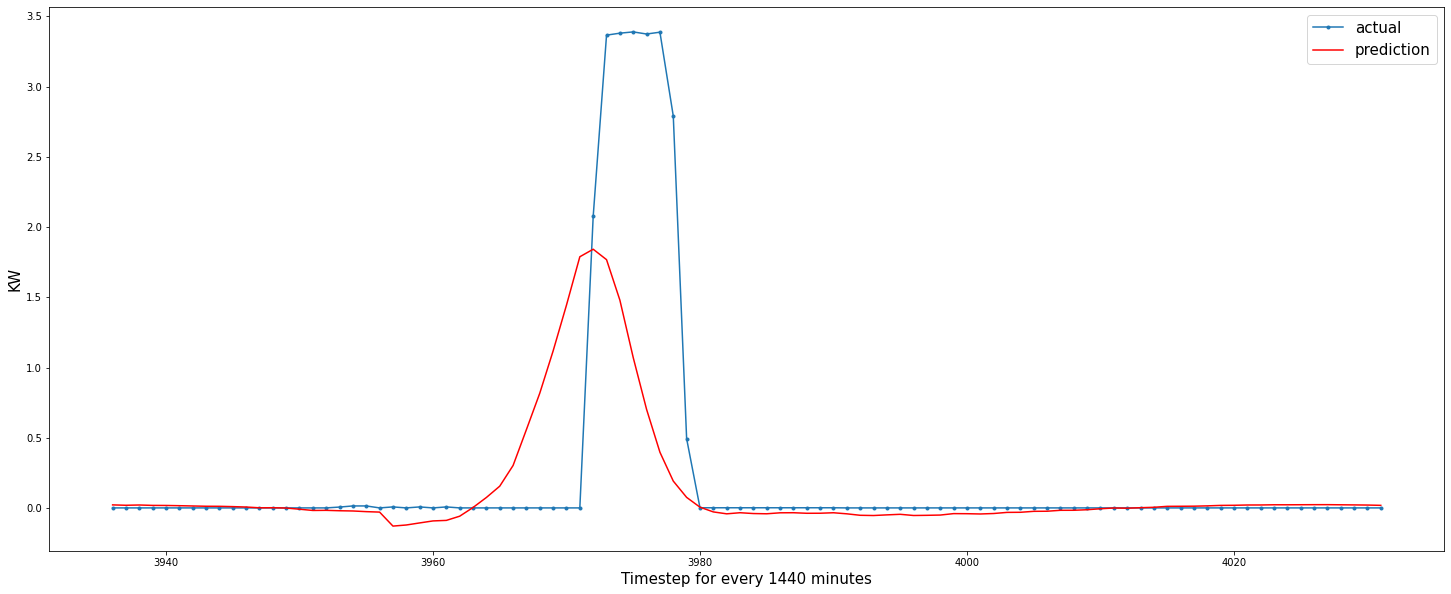

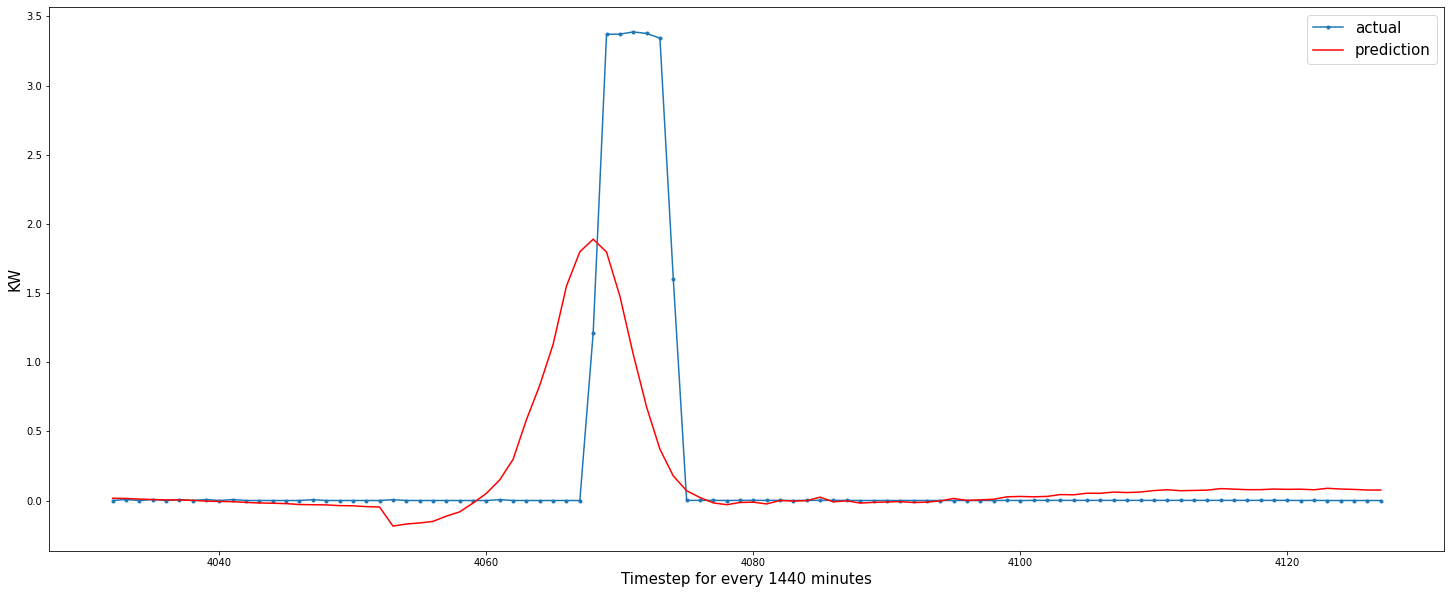

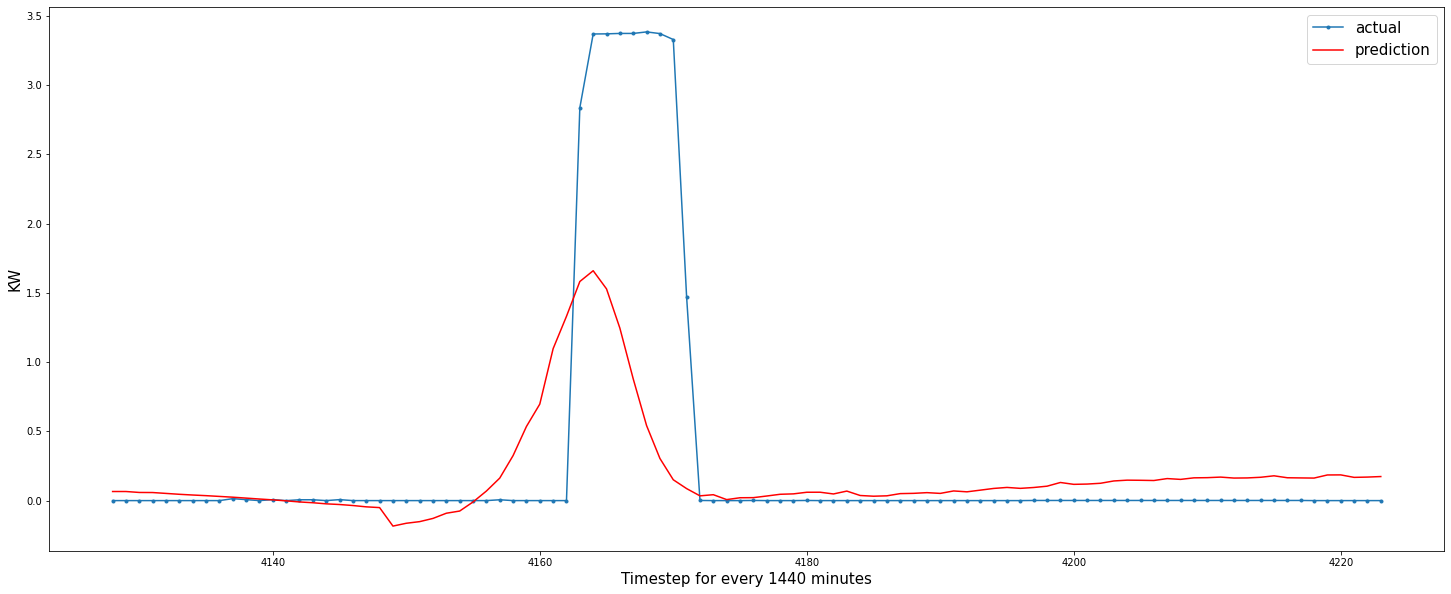

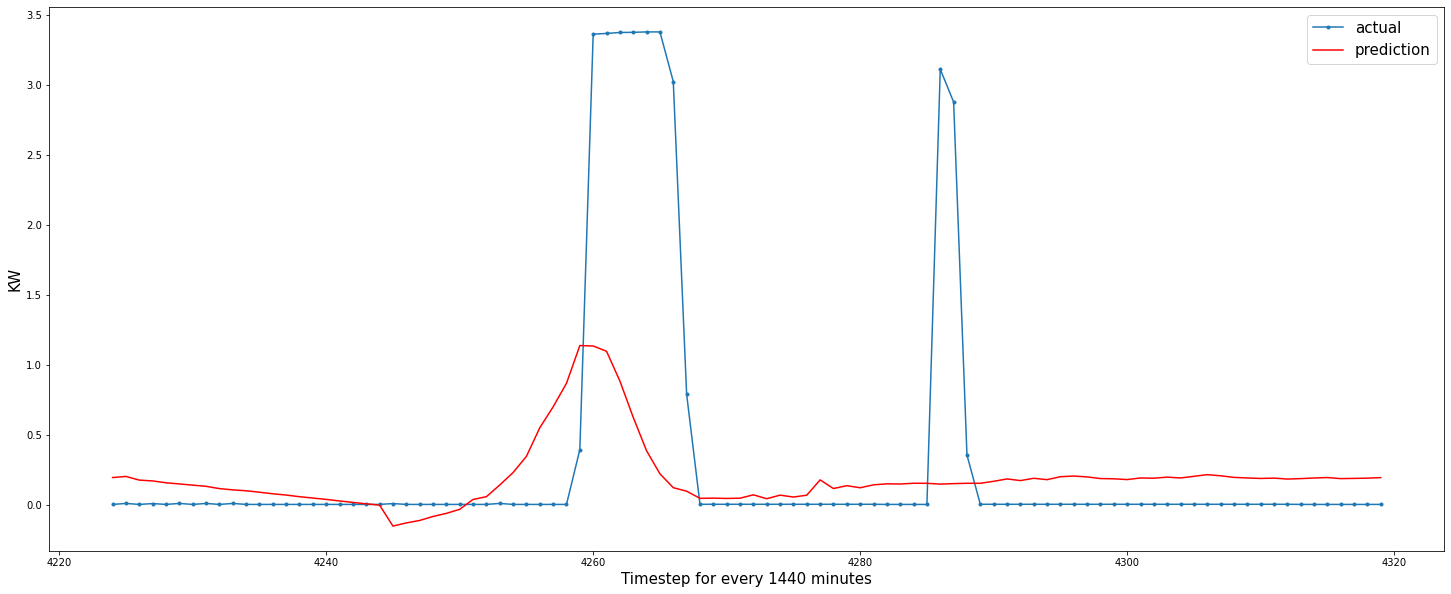

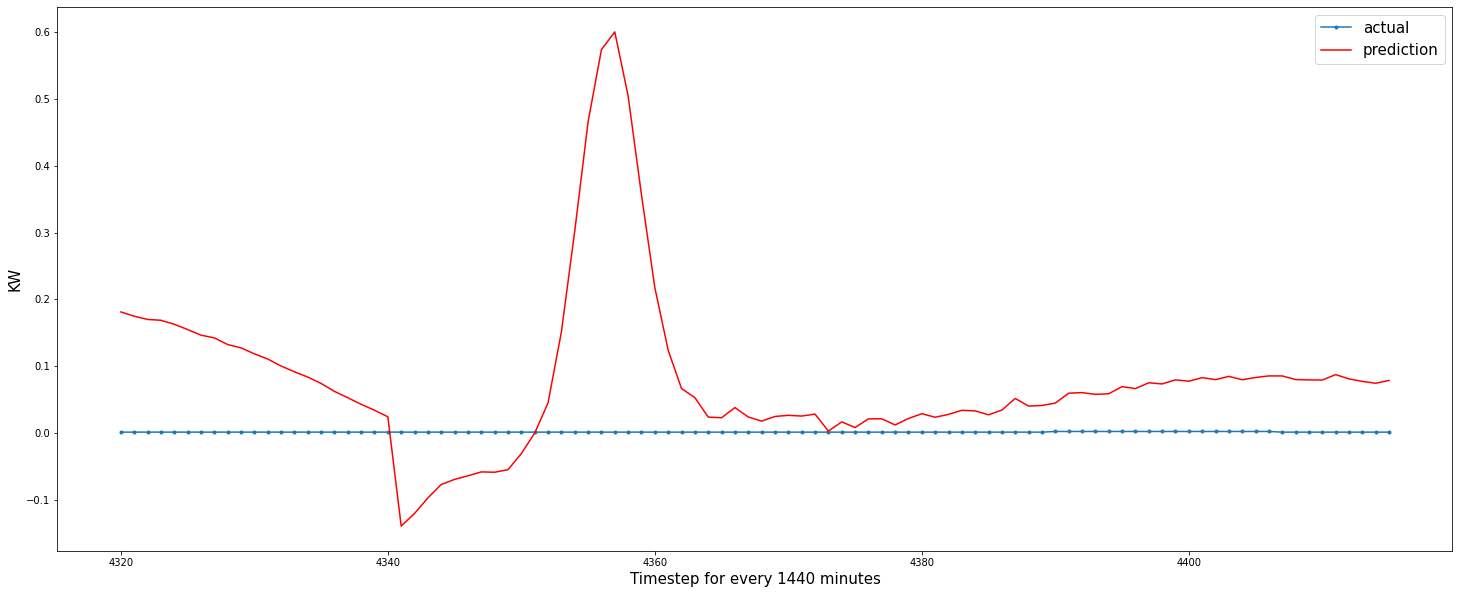

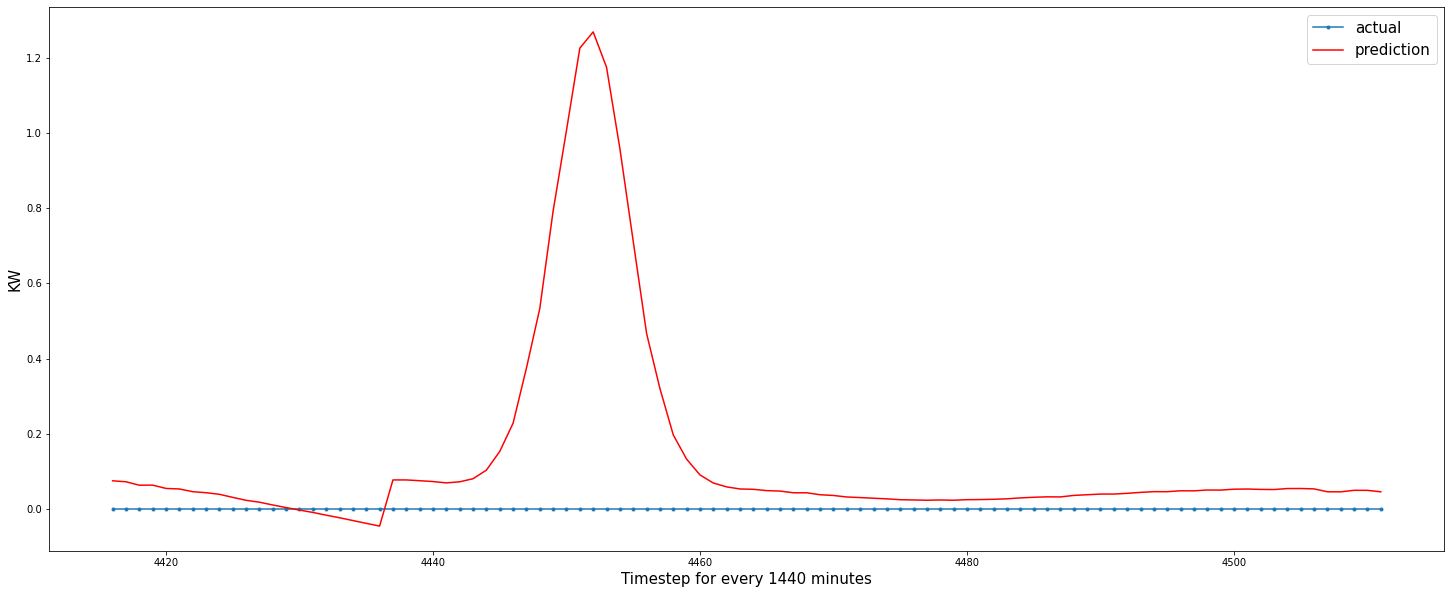

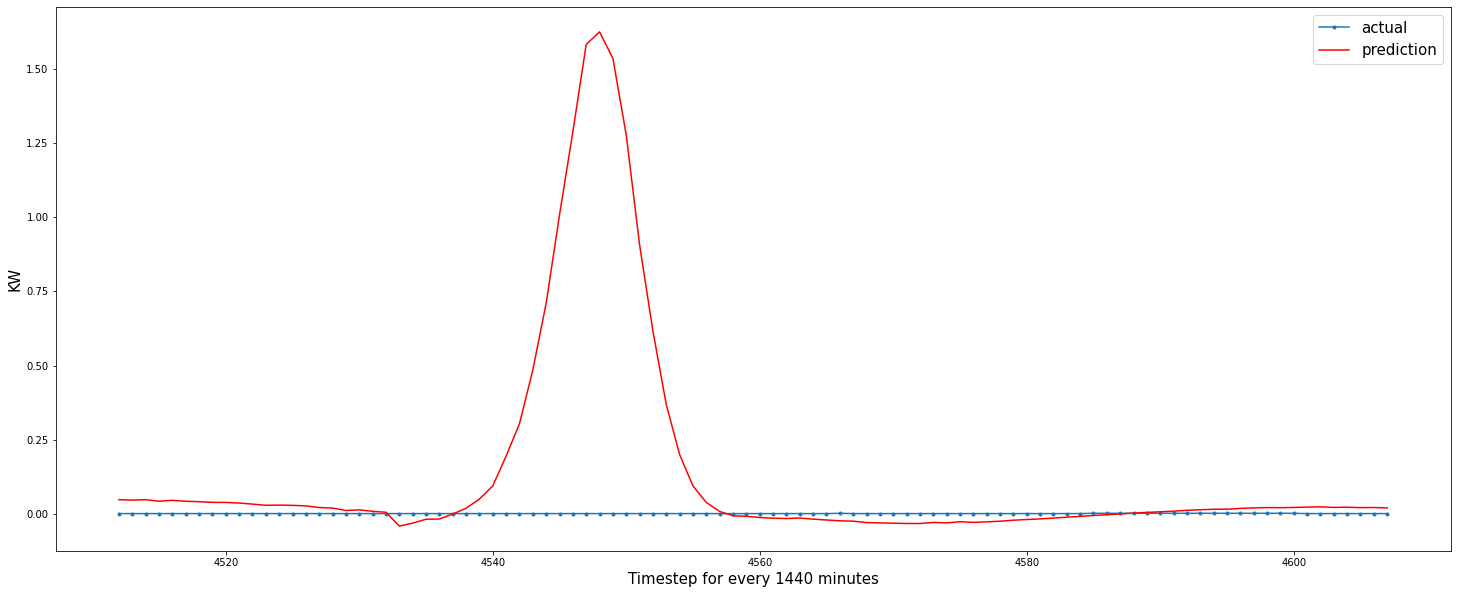

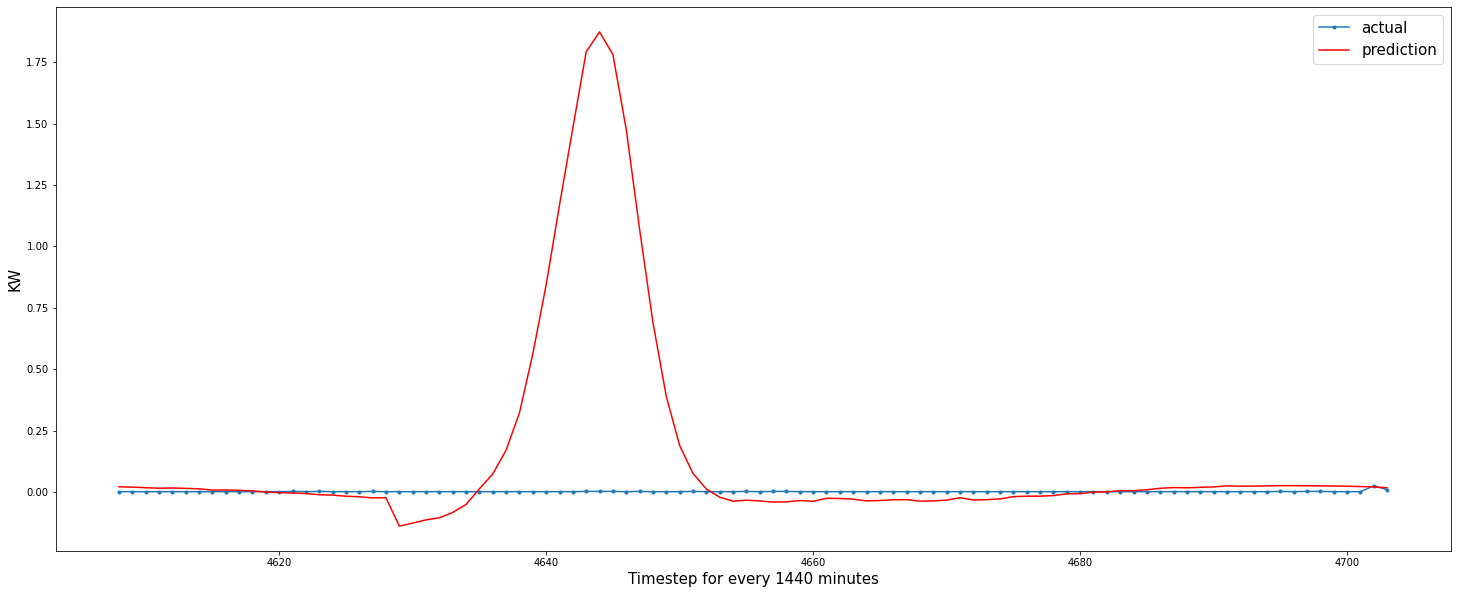

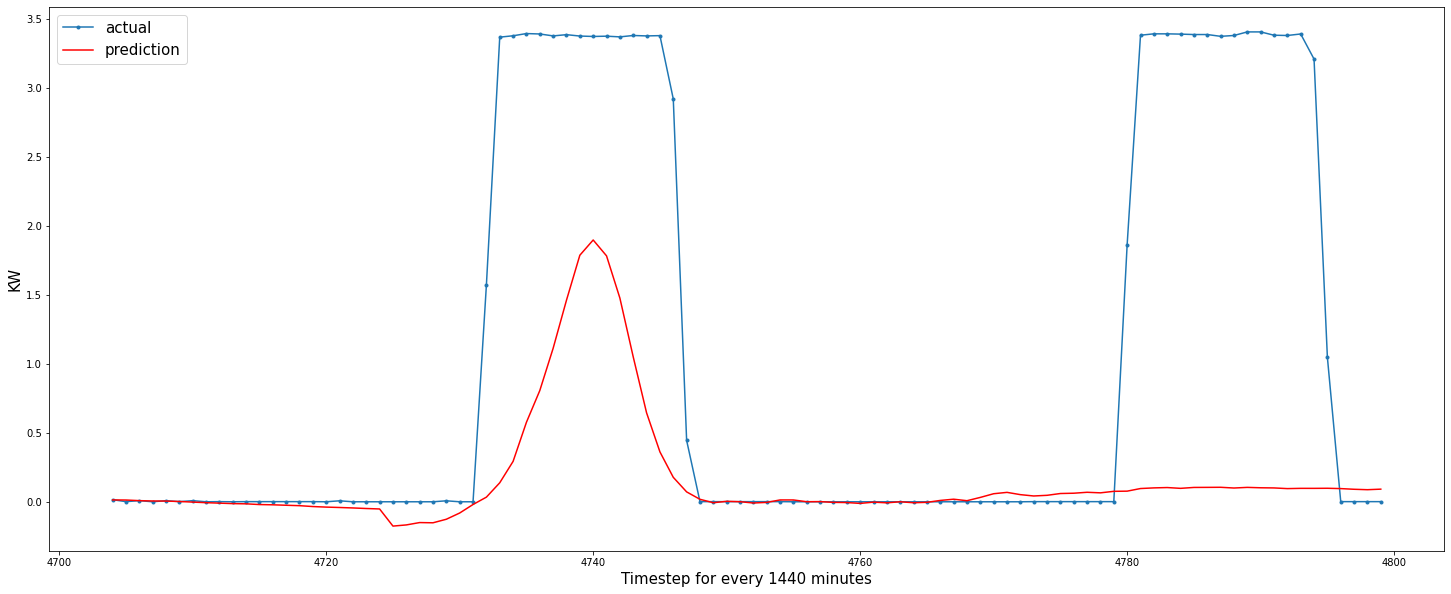

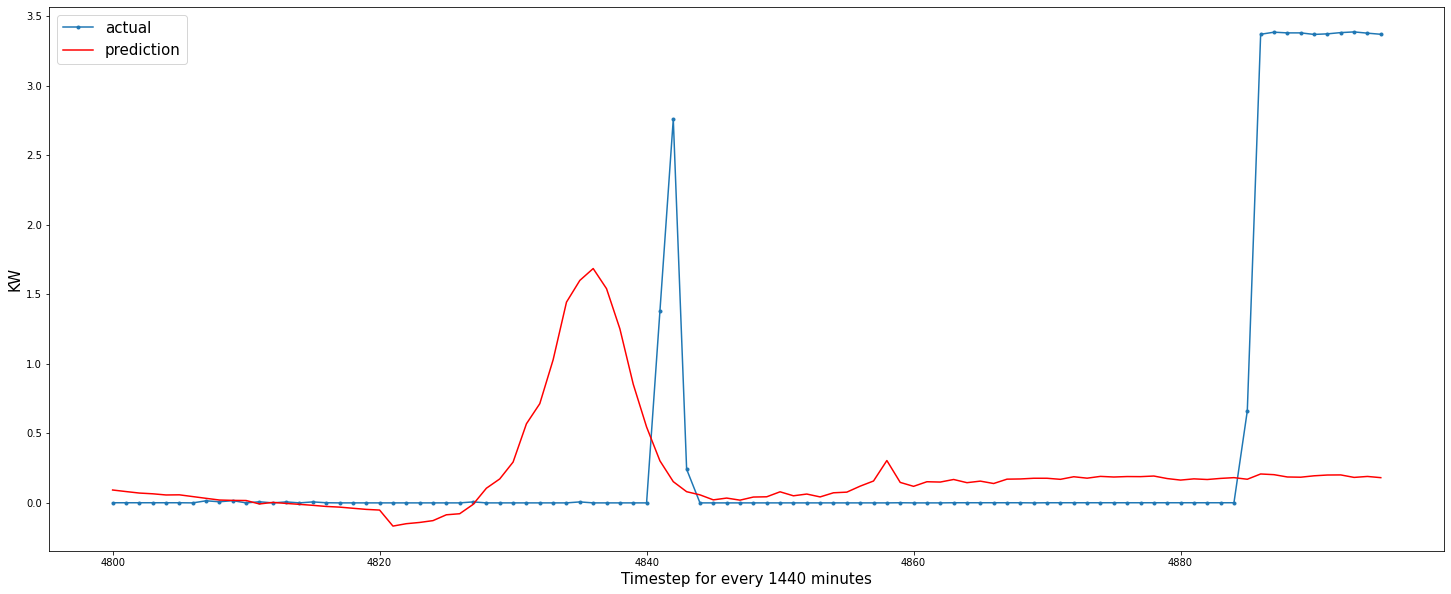

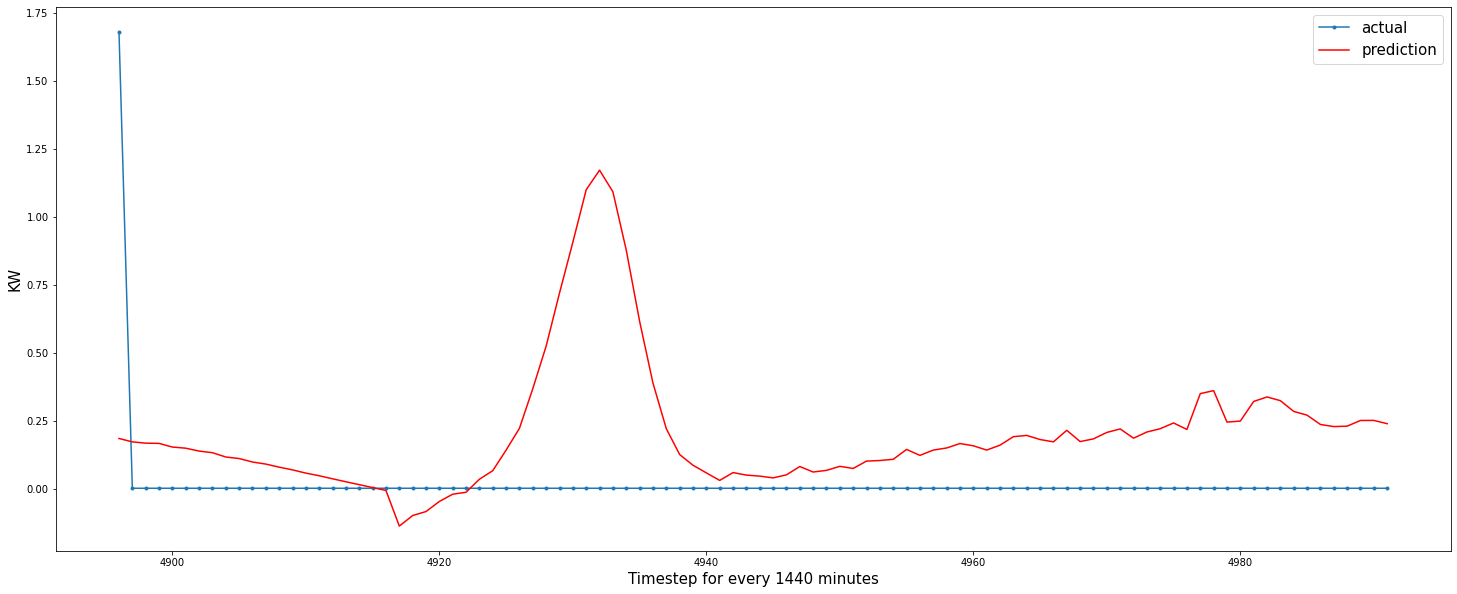

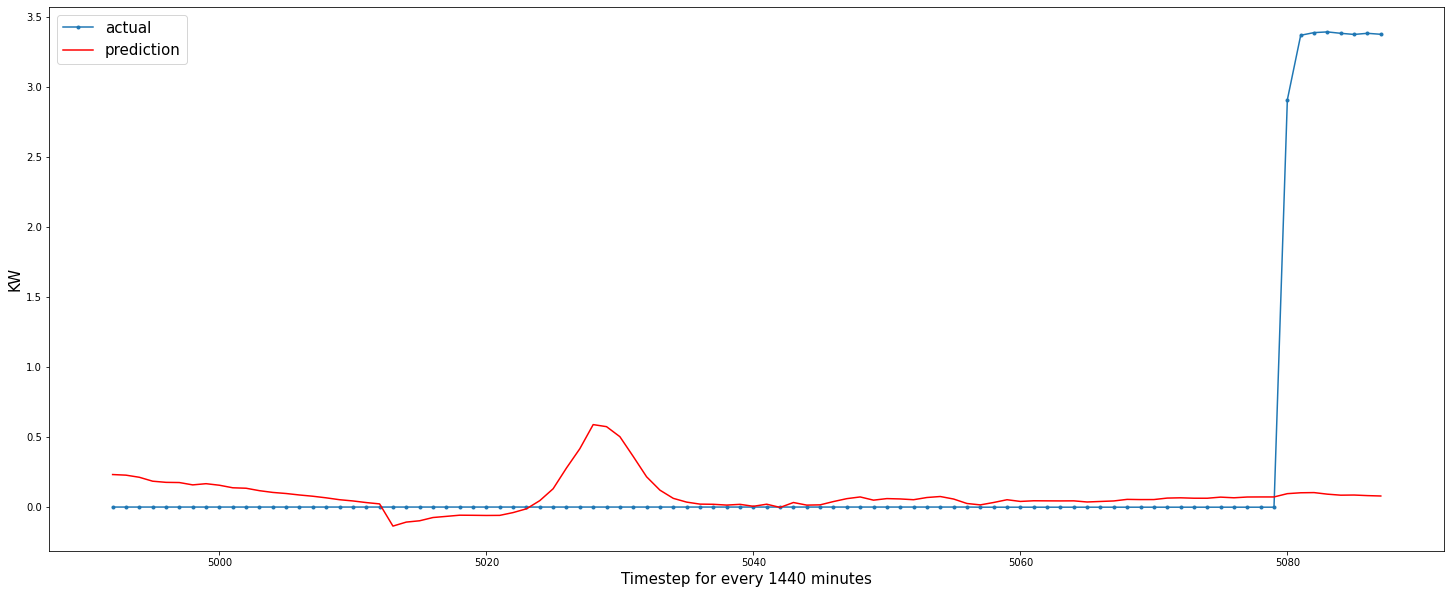

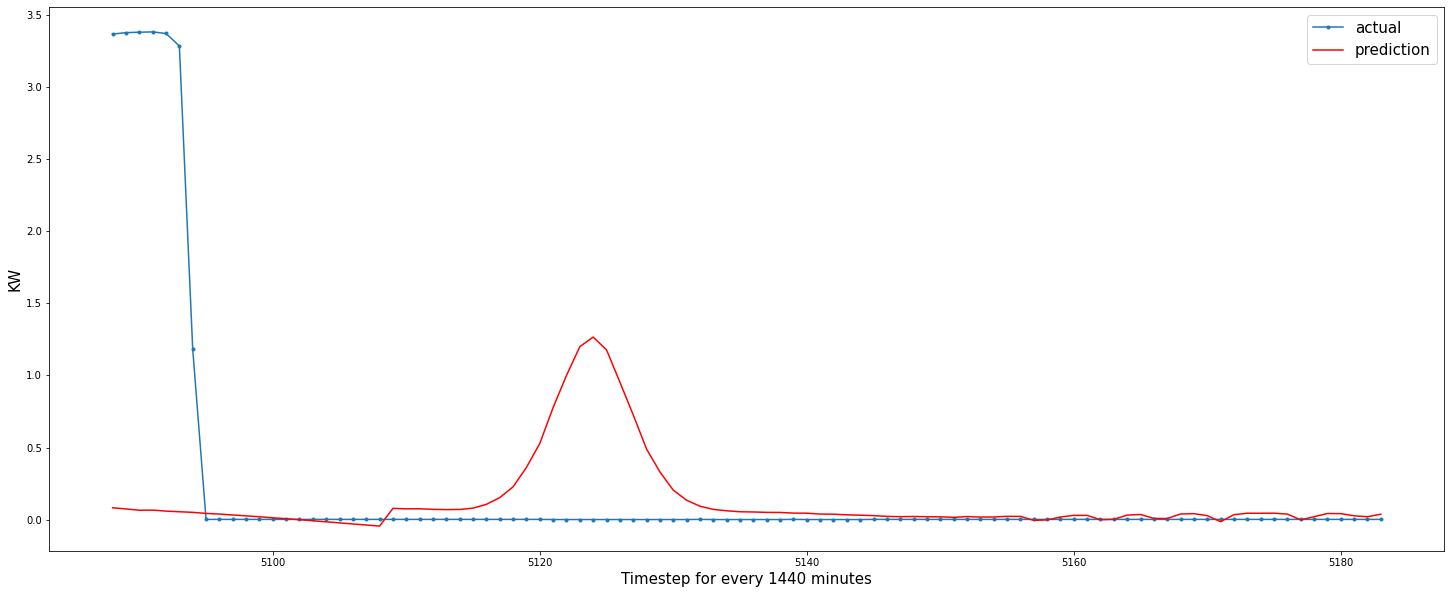

In [42]:
y=0
for i in range(96,5205,96):
    aa=[x for x in range(y,i)]
    plt.figure(figsize=(25,10)) 
    plt.plot(aa, inv_y[y:i], marker='.', label="actual")
    plt.plot(aa, inv_yhat[y:i], 'r', label="prediction")
    y = i
    plt.ylabel('KW', size=15)
    plt.xlabel('Timestep for every 1440 minutes', size=15)
    plt.legend(fontsize=15)
    plt.show()

In [43]:
X_test

array([[0.23074188, 0.78947368, 0.33333333],
       [0.15276132, 0.8       , 0.33333333],
       [0.12538516, 0.81052632, 0.33333333],
       ...,
       [0.16887888, 0.97894737, 0.        ],
       [0.1577388 , 0.98947368, 0.        ],
       [0.15122067, 1.        , 0.        ]])

In [45]:
model.save('EVmodel.h5')

<AxesSubplot:>

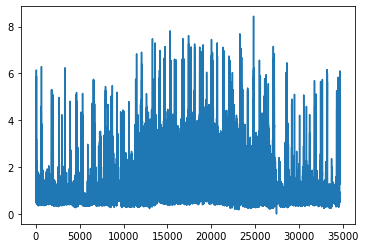

In [48]:
df['house'].plot()